# Well and Grace Drought Analysis Code
Written by Danielle Tadych

 The purpose of this script is to analyze our master water level database and GRACE data for various types of drought. 

## Loading packages and files

In [217]:
import Custom_functions as cf
from optparse import Values
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import datetime
from matplotlib.transforms import Bbox
import numpy as np
import pandas as pd
from shapely.geometry import box
import geopandas as gp
#import earthpy as et
import scipy.stats as sp
from scipy.stats import kendalltau, pearsonr, spearmanr
import pymannkendall as mk

# Data paths
datapath = '../Data/Input_files/'
outputpath = '../Data/Output_files/'
shapepath = '../Data/Shapefiles/'
figurepath = '../Data/Figures/'

In [218]:
# %%  ==== Reading in the data ====
filename_georeg = 'georeg_reproject_fixed.shp'
filepath = os.path.join(shapepath, filename_georeg)
georeg = gp.read_file(filepath)
# georeg.plot(cmap='viridis')

georeg['GEOREGI_NU'] = georeg['GEOREGI_NU'].astype('int64')
georeg.info()

# Read in the annual time series database
filename_ts = 'Wells55_GWSI_WLTS_DB_annual_updated_thresh15.csv'
filepath = os.path.join(outputpath, filename_ts)
print(filepath)
annual_db = pd.read_csv(filepath, header=1, index_col=0)

annual_db = annual_db[1:168102]
annual_db.index.astype('int64')
annual_db2 = annual_db.reset_index(inplace=True)
annual_db2 = annual_db.rename(columns = {'year':'Combo_ID'})
annual_db2.head()

# For regulation
filepath = outputpath+'Waterlevels_Regulation_updated_thresh15.csv'
cat_wl2_reg = pd.read_csv(filepath, index_col=0)
cat_wl2_reg.head()

filepath = outputpath+'Waterlevels_Regulation_updated_MAX_thresh15.csv'
cat_wl2_reg_max = pd.read_csv(filepath, index_col=0)
cat_wl2_reg_max.head()

filepath = outputpath+'Waterlevels_Regulation_updated_MIN_thresh15.csv'
cat_wl2_reg_min = pd.read_csv(filepath, index_col=0)
cat_wl2_reg_min.head()

# For Access to SW
filepath = outputpath+'Waterlevels_AccesstoSW_updated_thresh15.csv'
cat_wl2_SW = pd.read_csv(filepath, index_col=0)
cat_wl2_SW.head()

filepath = outputpath+'Waterlevels_AccesstoSW_updated_MAX_thresh15.csv'
cat_wl2_SW_max = pd.read_csv(filepath, index_col=0)
cat_wl2_SW_max.head()

filepath = outputpath+'Waterlevels_AccesstoSW_updated_MIN_thresh15.csv'
cat_wl2_SW_min = pd.read_csv(filepath, index_col=0)
cat_wl2_SW_min.head()

# Read in the drought indices
drought_indices = pd.read_csv(datapath+'Yearly_DroughtIndices.csv')
drought_indices = drought_indices.set_index('In_year')
# drought_indices

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GEO_Region  11 non-null     object  
 1   GEOREGI_NU  11 non-null     int64   
 2   Water_CAT   11 non-null     object  
 3   Loc         11 non-null     object  
 4   Regulation  11 non-null     object  
 5   geometry    11 non-null     geometry
dtypes: geometry(1), int64(1), object(4)
memory usage: 656.0+ bytes
../Data/Output_files/Wells55_GWSI_WLTS_DB_annual_updated_thresh15.csv


In [219]:
# %% Creating colors
c_1 = '#8d5a99' # Reservation
c_2 = "#d7191c" # Regulated with CAP (Water Category Color)
c_3 = '#e77a47' # Regulated without CAP (Water Category Color)
c_4 = '#2cbe21' # Lower CO River - SW (Water Category Color)
c_5 = '#2f8c73' # Upper CO River - Mixed (Water Category Color)
c_6 = '#6db7e8' # SE - GW
c_7 = '#165782' # NW - GW (Water Category color)
c_8 = '#229ce8' # SC - GW
c_9 = '#1f78b4' # NE - GW
c_10 = '#41bf9e' # N - Mixed
c_11 = '#7adec4' # C - Mixed
drought_color = '#ffa6b8'
wet_color = '#b8d3f2'

reg_colors = [c_2,c_7]
georeg_colors = [c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11]
SW_colors = [c_2,c_3,c_4,c_5,c_7]

bar_watercatc = [c_2,c_3,c_4,c_5,c_7]


# Color blind palette
# https://jacksonlab.agronomy.wisc.edu/2016/05/23/15-level-colorblind-friendly-palette/
blind =["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

# Matching new map

cap = '#77A8A5' #'#C6652B'
# noCAP = '#EDE461' # This is one from the map
noCAP = '#CCC339' # This color but darker for lines
GWdom = '#3B76AF'
mixed = '#6EB2E4'
swdom = '#469B76'

## Analysis
Wanting to look at 
1) Maximum Drawdown compared to the trend 
2) Anomalies 
3) Recovery

Decided from the drought indices analysis that the cutoff value is -3 for severe droughts


In [220]:
# %% Drought dictionary
DROUGHT_YEARS = {
        # 1:[1989,1990]
        # ,2:[1996]
        3:[2002,2003]
        ,4:[2006,2007]
        ,5:[2012,2013,2014]
        ,6:[2018]}

print(DROUGHT_YEARS)

{3: [2002, 2003], 4: [2006, 2007], 5: [2012, 2013, 2014], 6: [2018]}


In [221]:
#%% Pre-drought
# PREDROUGHT_YEARS = {1:[1988]
#         ,2:[1995]
#         ,3:[2001]
#         ,4:[2005]
#         ,5:[2011]
#         ,6:[2017]}

PREDROUGHT_YEARS = {1:[*range(1975,1988,1)]
        ,2:[*range(1991,1995,1)]
        ,3:[*range(1997,2001,1)]
        ,4:[*range(2004,2005,1)]
        ,5:[*range(2006,2011,1)]
        ,6:[*range(2015,2017,1)]}

print(PREDROUGHT_YEARS)

{1: [1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987], 2: [1991, 1992, 1993, 1994], 3: [1997, 1998, 1999, 2000], 4: [2004], 5: [2006, 2007, 2008, 2009, 2010], 6: [2015, 2016]}


In [222]:
#%% Print the average PDSI and PHDI values

ds = drought_indices.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


pdsi_avg = ds.groupby(['Status']).mean()
pdsi_avg

PDSI      PHDI
Status                        
Drought 3  -4.109167 -4.109167
Drought 4  -3.658750 -3.658750
Drought 5  -3.164722 -3.164722
Drought 6  -3.342500 -4.258333
Normal-Wet -0.042873  0.043443

### Regulated versus Unregulated - Step by step

In [223]:
# %% Figure out which water level database you want
cat_wl2 = cat_wl2_reg.copy() 

Min_year_of_Study = 2000

# Water Analysis period
wlanalysis_period = cat_wl2[(cat_wl2.index>=Min_year_of_Study)&(cat_wl2.index<=2020)]

del wlanalysis_period['Res']
wlanalysis_period.head()

R           U
index                        
2000   256.157179  225.693006
2001   242.725513  228.385177
2002   252.610456  219.867554
2003   253.092475  223.212062
2004   248.647829  219.202956

For comparing to drought indices

In [224]:
# Some functions since it's not pulling from cf
def kendall_pval(x,y):
        return kendalltau(x,y)[1]
    
def pearsonr_pval(x,y):
        return pearsonr(x,y)[1]
    
def spearmanr_pval(x,y):
        return spearmanr(x,y)[1]

In [225]:
drought_indices

PDSI      PHDI
In_year                    
1975    -1.415833 -1.415833
1976    -0.960000 -0.881667
1977    -1.915000 -1.915000
1978     2.998333  2.831667
1979     5.378333  5.378333
1980     1.709167  3.659167
1981    -2.196667 -2.196667
1982     0.982500  0.443333
1983     4.949167  4.949167
1984     0.318333  1.910000
1985     3.086667  3.380833
1986    -0.241667  0.529167
1987     0.290833  0.568333
1988     0.209167  0.665000
1989    -3.215000 -3.215000
1990    -1.347500 -2.733333
1991     0.530833  0.553333
1992     3.444167  3.444167
1993     3.324167  5.635833
1994    -0.838333 -0.409167
1995     0.630833  1.549167
1996    -4.137500 -4.137500
1997    -1.864167 -3.149167
1998     1.368333  2.311667
1999    -1.272500 -1.407500
2000    -2.534167 -3.545833
2001    -0.102500 -0.806667
2002    -4.600000 -4.600000
2003    -3.618333 -3.618333
2004    -2.030833 -3.150000
2005     1.653333  3.544167
2006    -3.385000 -3.385000
2007    -3.932500 -3.932500
2008    -1.473333 -1.473333
2009    -2.695000 -3.035833
2010     0.865000  0.513333
2011    -2.496667 -2.496667
2012    -3.547500 -3.547500
2013    -2.658333 -2.658333
2014    -3.288333 -3.288333
2015    -0.597500 -1.525833
2016    -2.055833 -2.055833
2017    -1.717500 -1.717500
2018    -3.342500 -4.258333
2019     0.549167 -0.137500
2020     1.190000  1.190000

In [226]:
drought_indices = drought_indices[(drought_indices.index>=Min_year_of_Study)&(drought_indices.index<=2020)]

In [227]:

# %% If running a shifted correlation analysis,
#    change this to however many # years; 0 is no lag
lag = 0
indice = 'PDSI'


columns = ds.columns
column_list = ds.columns.tolist()

ds = wlanalysis_period
print('Kendall Correlation coefficient')
for i in column_list:
        # print(' '+i+':')
        print(' '+str(i)+':')
# To normalize the data 
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices[indice].shift(lag)
        print('  tau = ',round(df1.corr(df2, method='kendall'),3))
        print('  pval = ',round(df1.corr(df2, method=kendall_pval),4))

# %%
print('Spearman Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices[indice].shift(lag)
        print('  rho = ',round(df1.corr(df2, method='spearman'),3))
        print('  pval = ',round(df1.corr(df2, method=spearmanr_pval),4))

# %%
print('Pearson Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices[indice].shift(lag)
        r = df1.corr(df2, method='pearson')
        print('  rsq = ',round(r*r,3))
        print('  pval = ',round(df1.corr(df2, method=pearsonr_pval),4))

Kendall Correlation coefficient
 PDSI:


KeyError: 'PDSI'

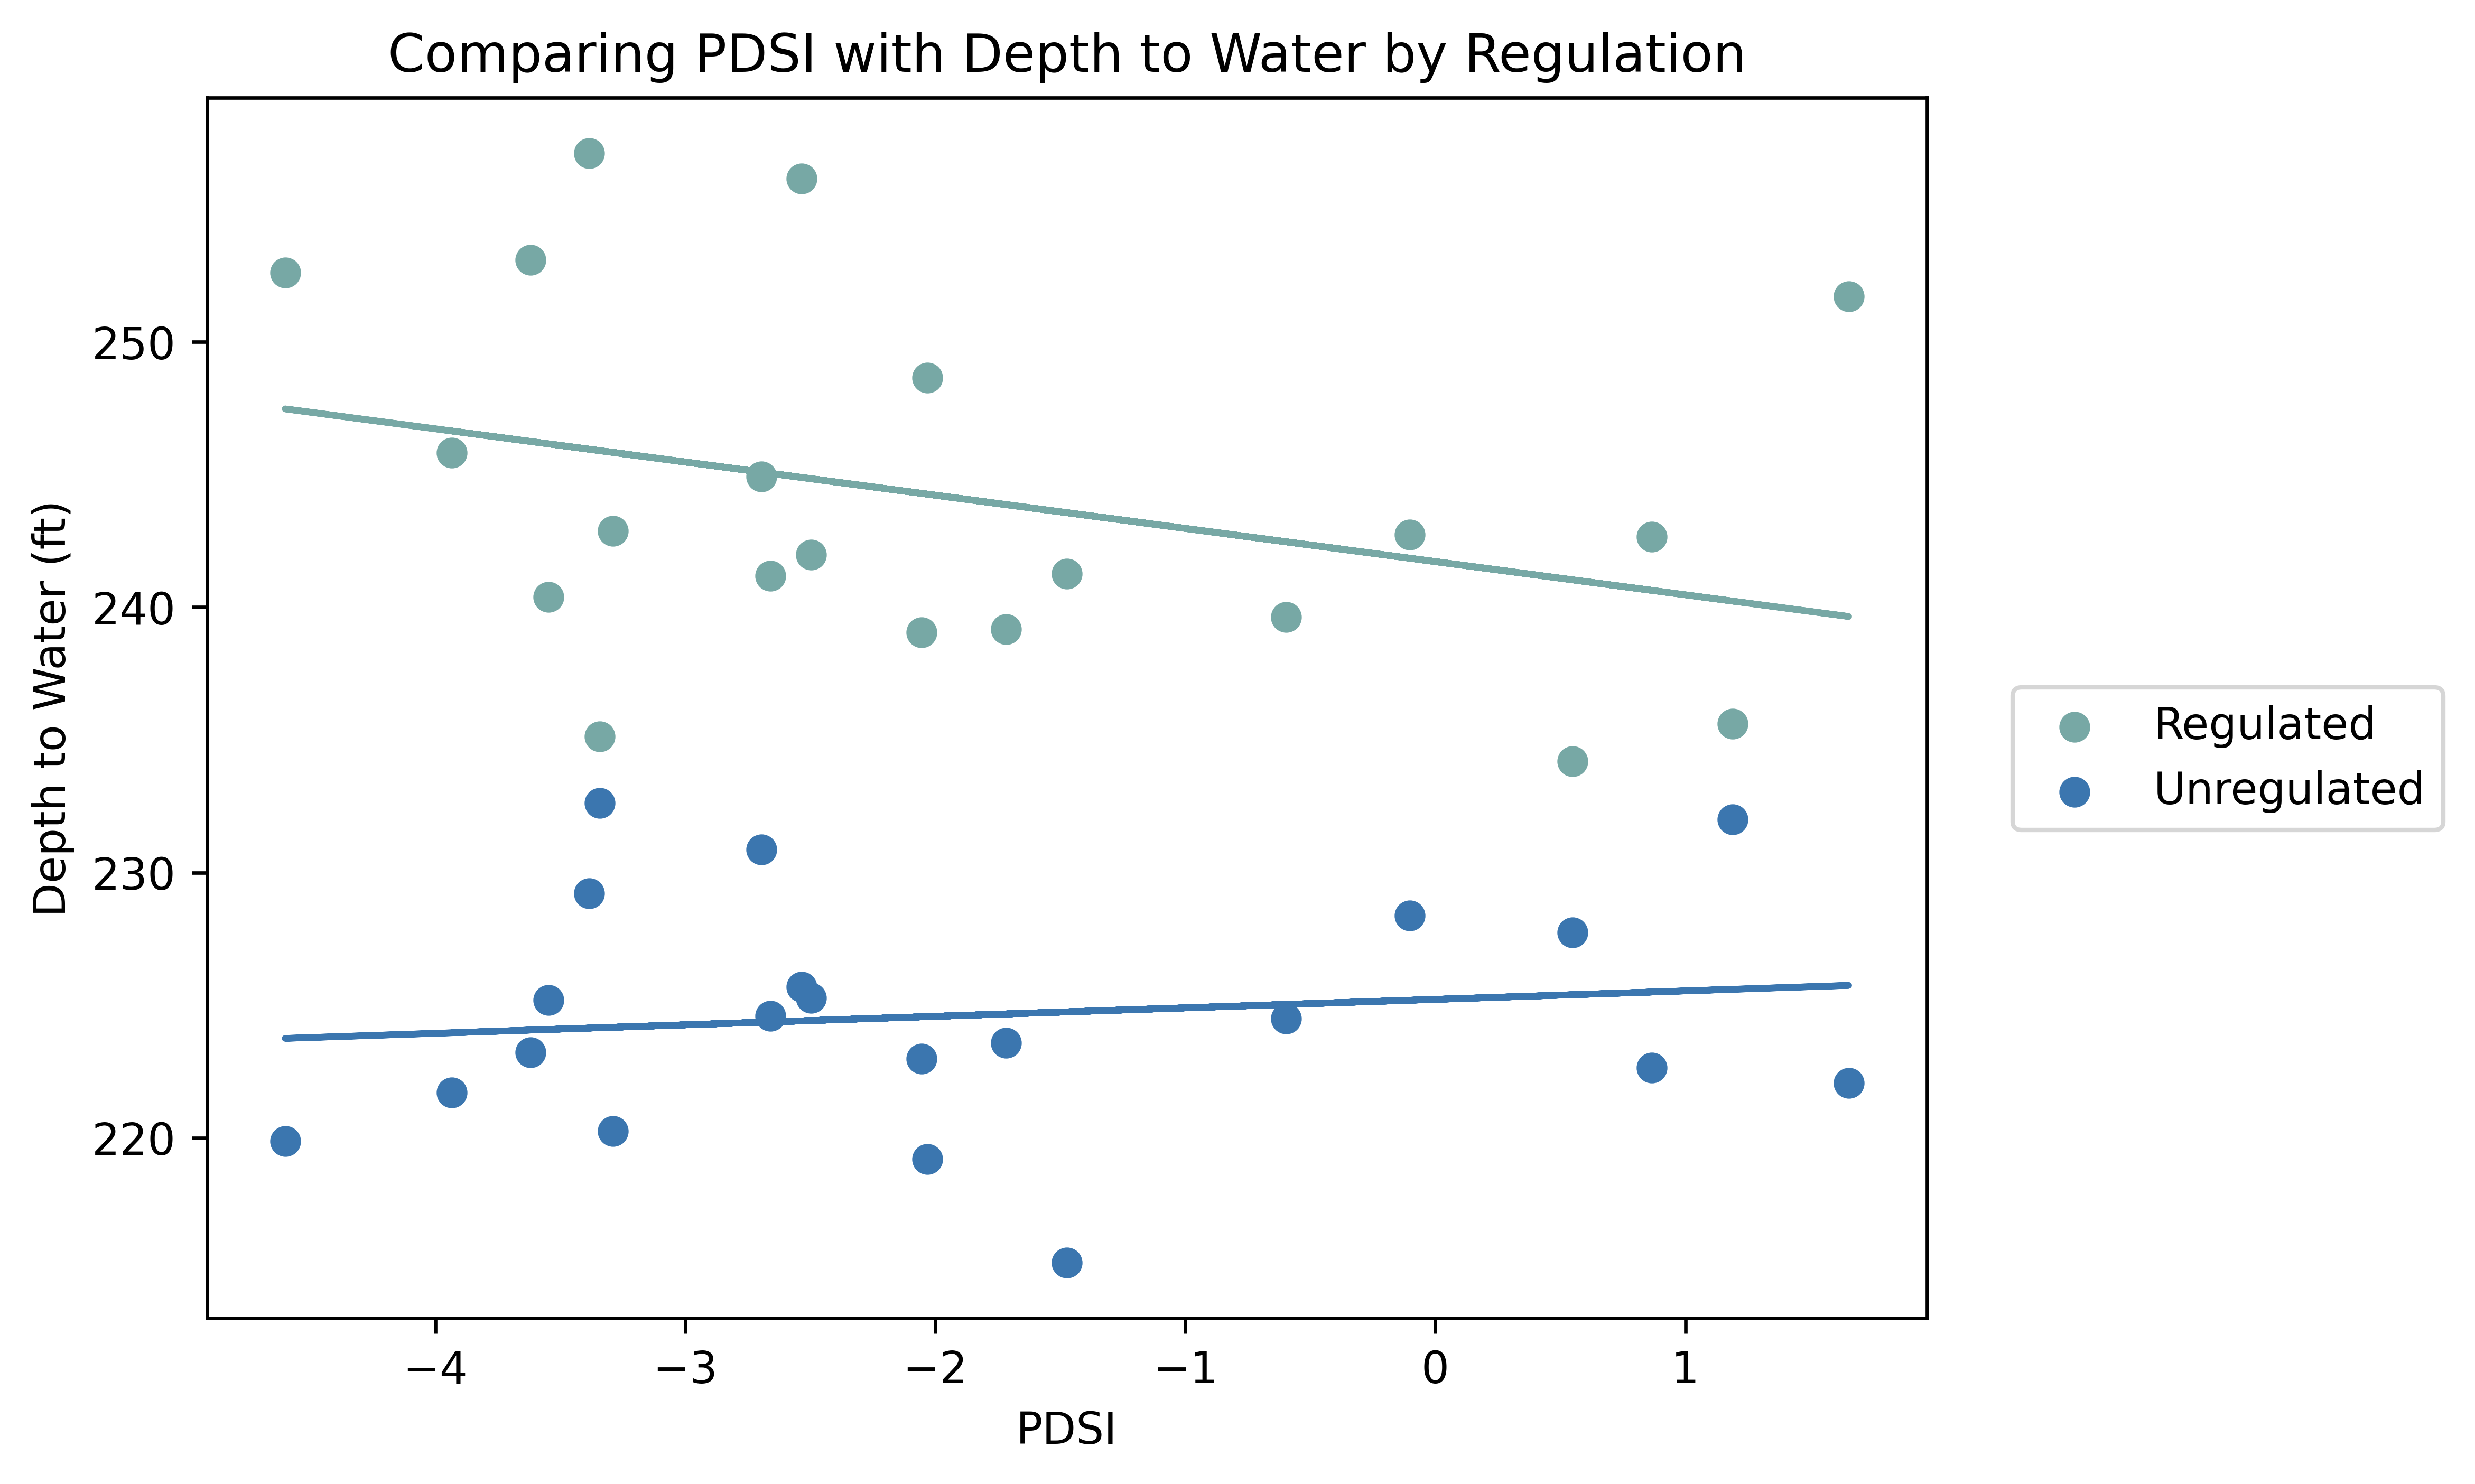

In [228]:
# %% Scatterplot of correlation values
ds = wlanalysis_period
# name = 'Comparing PDSI with Depth to Water by Access to SW'
name = 'Comparing '+indice+' with Depth to Water by Regulation'
# del ds['Res']
columns = ds.columns
column_list = ds.columns.tolist()
# betterlabels = ['Receives CAP (Regulated)','GW Dominated (Regulated)','Surface Water Dominated','GW Dominated','Mixed Source'] 
betterlabels = ['Regulated','Unregulated'] 
colors=[cap, GWdom]
# colors=[cap,noCAP, swdom, mixed, GWdom]

fig, ax = plt.subplots(figsize = (7,5))
x = drought_indices[indice]
for i,j,k in zip(column_list
                # ,reg_colors
                # , SW_colors
                , colors
                , betterlabels
                ):
        y = ds[i]
        ax.scatter(x,y
                , label=k
                , color=j
                )
        # Trendline: 1=Linear, 2=polynomial
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        plt.plot(x, p(x),'-'
                , color=j
                # ,label=(k+' Trendline')
                )


ax.set_xlabel(indice)
ax.set_ylabel('Depth to Water (ft)')
ax.set_title(name,loc='center')
# ax.set_ylim(0,400)
fig.set_dpi(600)
plt.legend(loc = [1.05, 0.40])

plt.savefig(outputpath+name, bbox_inches='tight') 

For Calculating Anomlies

In [229]:
# Anomaly's
ds = wlanalysis_period.copy()
columns = ds.columns
column_list = ds.columns.tolist()
trend_df = wlanalysis_period.copy()
dtw_anomalys = pd.DataFrame()
for i in column_list:
        # Subtracting against the mean
        # dtw_anomalys[i] = wlanalysis_period[i] - wlanalysis_period[i].mean()
        
        # Subtracting against the slope
        df = ds[i]
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err = sp.linregress(x,y)
        # print(y)
        # slope, intercept = sp.linregress(x,y) 
        trend_df[i] = (wlanalysis_period.index*slope) + intercept
        dtw_anomalys[i] = wlanalysis_period[i] - trend_df[i]
        

dtw_anomalys.head()

R         U
index                    
2000   2.802871  3.467426
2001  -9.702516  5.921020
2002   1.108707 -2.835180
2003   2.517005  0.270750
2004  -1.001362 -3.976933

In [230]:

# %% If running a shifted correlation analysis,
#    change this to however many # years; 0 is no lag
lag = 0
indice = 'PDSI'


columns = ds.columns
column_list = ds.columns.tolist()

ds = dtw_anomalys
print('Kendall Correlation coefficient')
for i in column_list:
        # print(' '+i+':')
        print(' '+str(i)+':')
# To normalize the data 
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices[indice].shift(lag)
        print('  tau = ',round(df1.corr(df2, method='kendall'),3))
        print('  pval = ',round(df1.corr(df2, method=kendall_pval),4))

# %%
print('Spearman Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices[indice].shift(lag)
        print('  rho = ',round(df1.corr(df2, method='spearman'),3))
        print('  pval = ',round(df1.corr(df2, method=spearmanr_pval),4))

# %%
print('Pearson Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices[indice].shift(lag)
        r = df1.corr(df2, method='pearson')
        print('  rsq = ',round(r*r,3))
        print('  pval = ',round(df1.corr(df2, method=pearsonr_pval),4))

Kendall Correlation coefficient
 R:
  tau =  -0.105
  pval =  0.5306
 U:
  tau =  0.0
  pval =  1.0
Spearman Correlation coefficient
 R:
  rho =  -0.16
  pval =  0.4892
 U:
  rho =  -0.013
  pval =  0.9554
Pearson Correlation coefficient
 R:
  rsq =  0.06
  pval =  0.2825
 U:
  rsq =  0.003
  pval =  0.8199


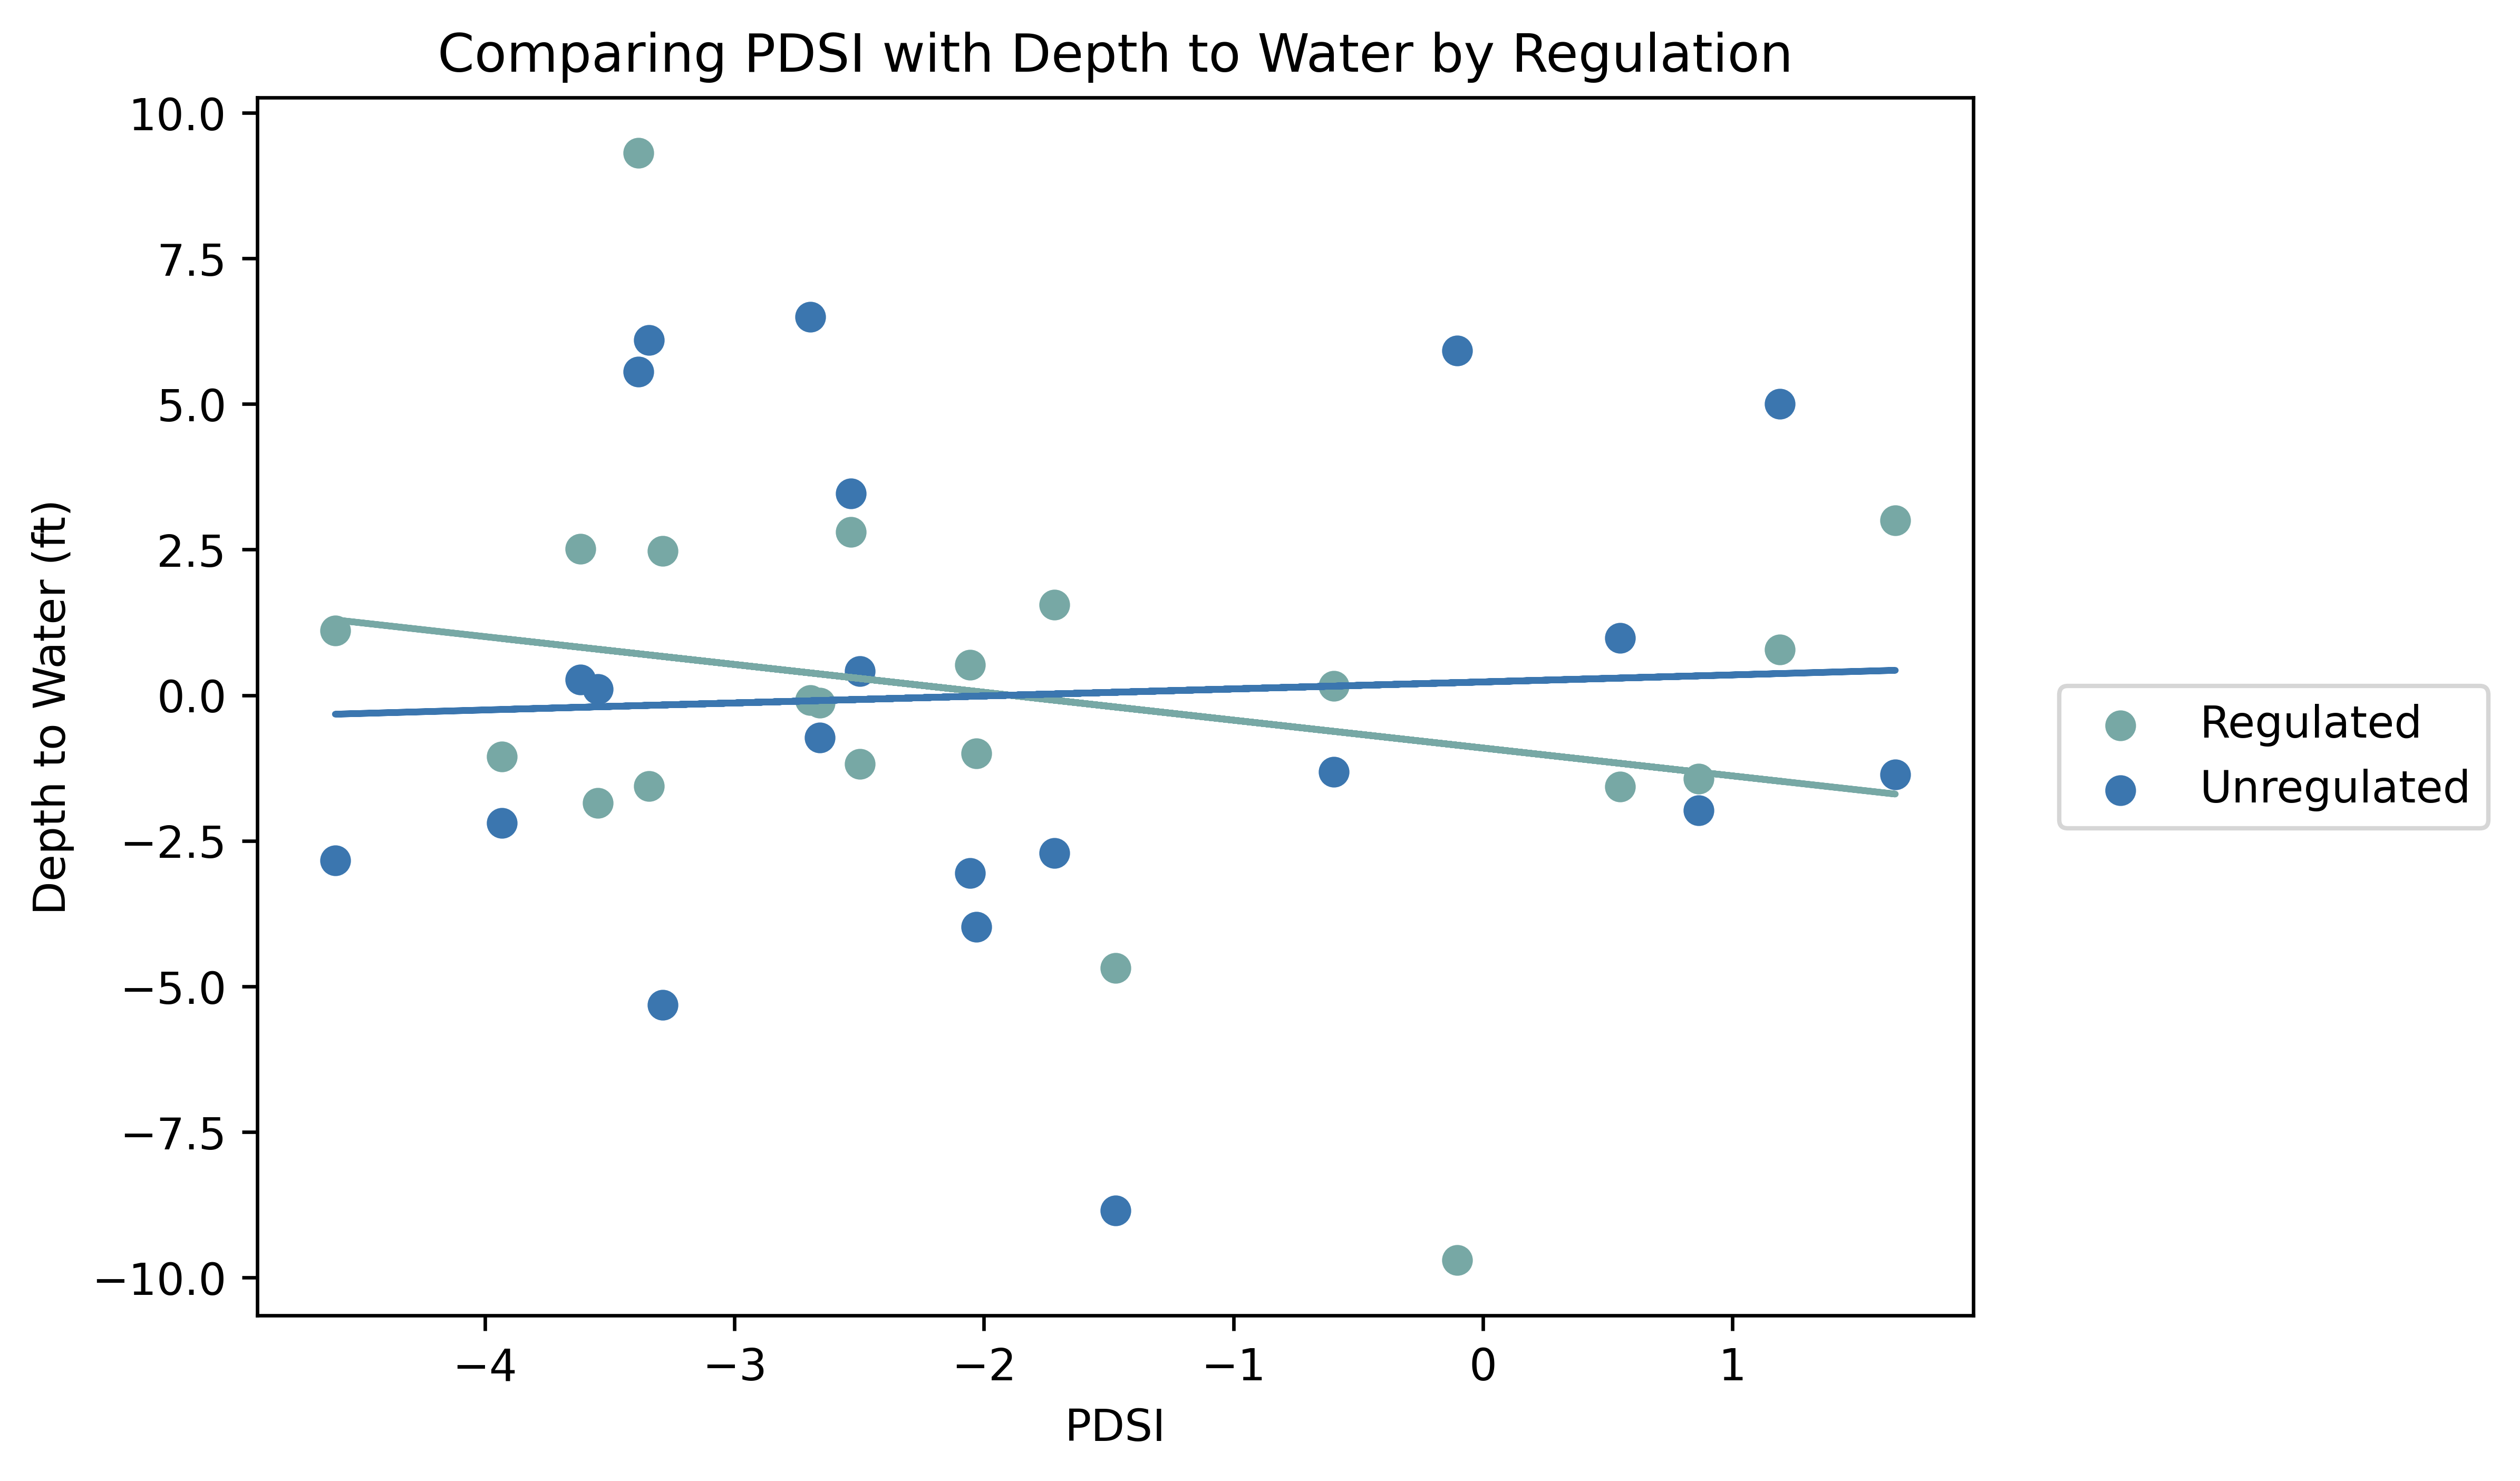

In [231]:
# %% Scatterplot of correlation values
ds = dtw_anomalys
# name = 'Comparing PDSI with Depth to Water by Access to SW'
name = 'Comparing '+indice+' with Depth to Water by Regulation'
# del ds['Res']
columns = ds.columns
column_list = ds.columns.tolist()
# betterlabels = ['Receives CAP (Regulated)','GW Dominated (Regulated)','Surface Water Dominated','GW Dominated','Mixed Source'] 
betterlabels = ['Regulated','Unregulated'] 
colors=[cap, GWdom]
# colors=[cap,noCAP, swdom, mixed, GWdom]

fig, ax = plt.subplots(figsize = (7,5))
x = drought_indices[indice]
for i,j,k in zip(column_list
                # ,reg_colors
                # , SW_colors
                , colors
                , betterlabels
                ):
        y = ds[i]
        ax.scatter(x,y
                , label=k
                , color=j
                )
        # Trendline: 1=Linear, 2=polynomial
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        plt.plot(x, p(x),'-'
                , color=j
                # ,label=(k+' Trendline')
                )


ax.set_xlabel(indice)
ax.set_ylabel('Depth to Water (ft)')
ax.set_title(name,loc='center')
# ax.set_ylim(0,400)
fig.set_dpi(600)
plt.legend(loc = [1.05, 0.40])

plt.savefig(outputpath+name, bbox_inches='tight') 

For PHDI

In [232]:

# %% If running a shifted correlation analysis,
#    change this to however many # years; 0 is no lag
lag = 0
indice = 'PHDI'


columns = ds.columns
column_list = ds.columns.tolist()

ds = dtw_anomalys
print('Kendall Correlation coefficient')
for i in column_list:
        # print(' '+i+':')
        print(' '+str(i)+':')
# To normalize the data 
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices[indice].shift(lag)
        print('  tau = ',round(df1.corr(df2, method='kendall'),3))
        print('  pval = ',round(df1.corr(df2, method=kendall_pval),4))

# %%
print('Spearman Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices[indice].shift(lag)
        print('  rho = ',round(df1.corr(df2, method='spearman'),3))
        print('  pval = ',round(df1.corr(df2, method=spearmanr_pval),4))

# %%
print('Pearson Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices[indice].shift(lag)
        r = df1.corr(df2, method='pearson')
        print('  rsq = ',round(r*r,3))
        print('  pval = ',round(df1.corr(df2, method=pearsonr_pval),4))

Kendall Correlation coefficient
 R:
  tau =  -0.095
  pval =  0.5706
 U:
  tau =  -0.01
  pval =  0.9762
Spearman Correlation coefficient
 R:
  rho =  -0.149
  pval =  0.5182
 U:
  rho =  -0.03
  pval =  0.8977
Pearson Correlation coefficient
 R:
  rsq =  0.016
  pval =  0.5876
 U:
  rsq =  0.001
  pval =  0.9106


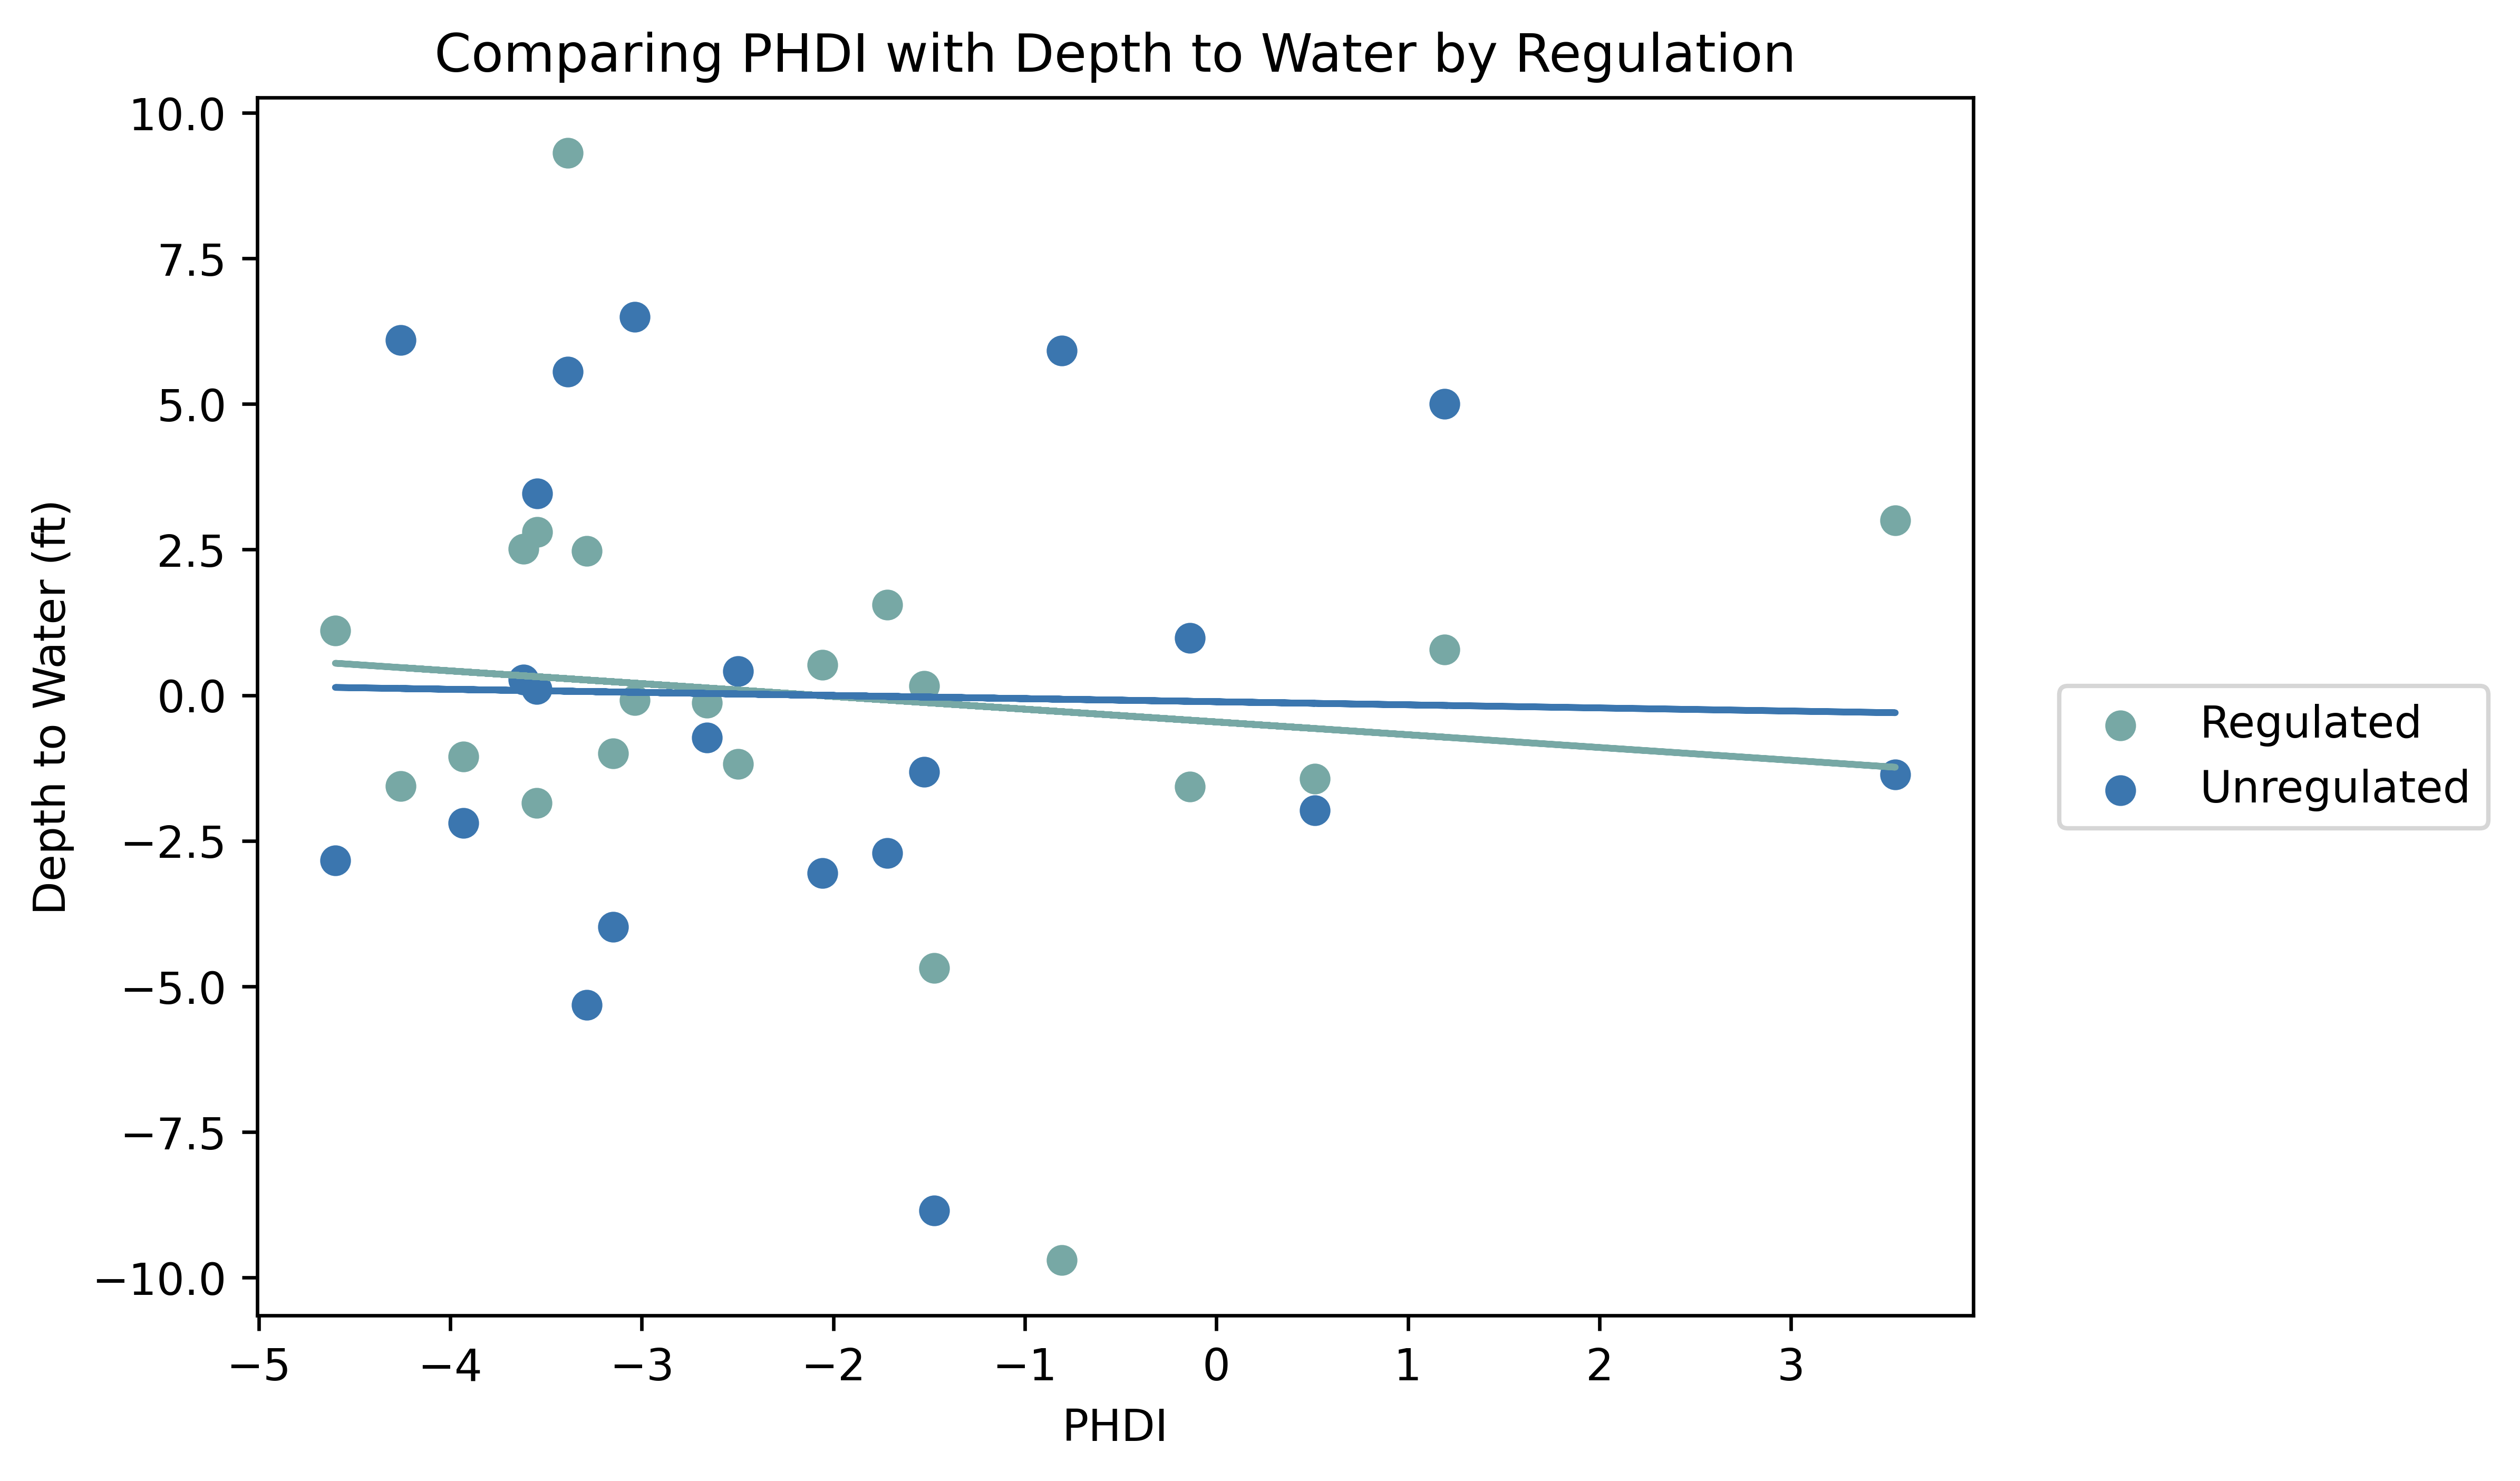

In [233]:
# Doing this for PHDI
indice = 'PHDI'
# %% Scatterplot of correlation values

ds = dtw_anomalys
# name = 'Comparing PDSI with Depth to Water by Access to SW'
name = 'Comparing '+indice+' with Depth to Water by Regulation'
# del ds['Res']
columns = ds.columns
column_list = ds.columns.tolist()
# betterlabels = ['Receives CAP (Regulated)','GW Dominated (Regulated)','Surface Water Dominated','GW Dominated','Mixed Source'] 
betterlabels = ['Regulated','Unregulated'] 
colors=[cap, GWdom]
# colors=[cap,noCAP, swdom, mixed, GWdom]

fig, ax = plt.subplots(figsize = (7,5))
x = drought_indices[indice]
for i,j,k in zip(column_list
                # ,reg_colors
                # , SW_colors
                , colors
                , betterlabels
                ):
        y = ds[i]
        ax.scatter(x,y
                , label=k
                , color=j
                )
        # Trendline: 1=Linear, 2=polynomial
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        plt.plot(x, p(x),'-'
                , color=j
                # ,label=(k+' Trendline')
                )


ax.set_xlabel(indice)
ax.set_ylabel('Depth to Water (ft)')
ax.set_title(name,loc='center')
# ax.set_ylim(0,400)
fig.set_dpi(600)
plt.legend(loc = [1.05, 0.40])

plt.savefig(outputpath+name, bbox_inches='tight') 

Creating a timeseries plot of anomalies

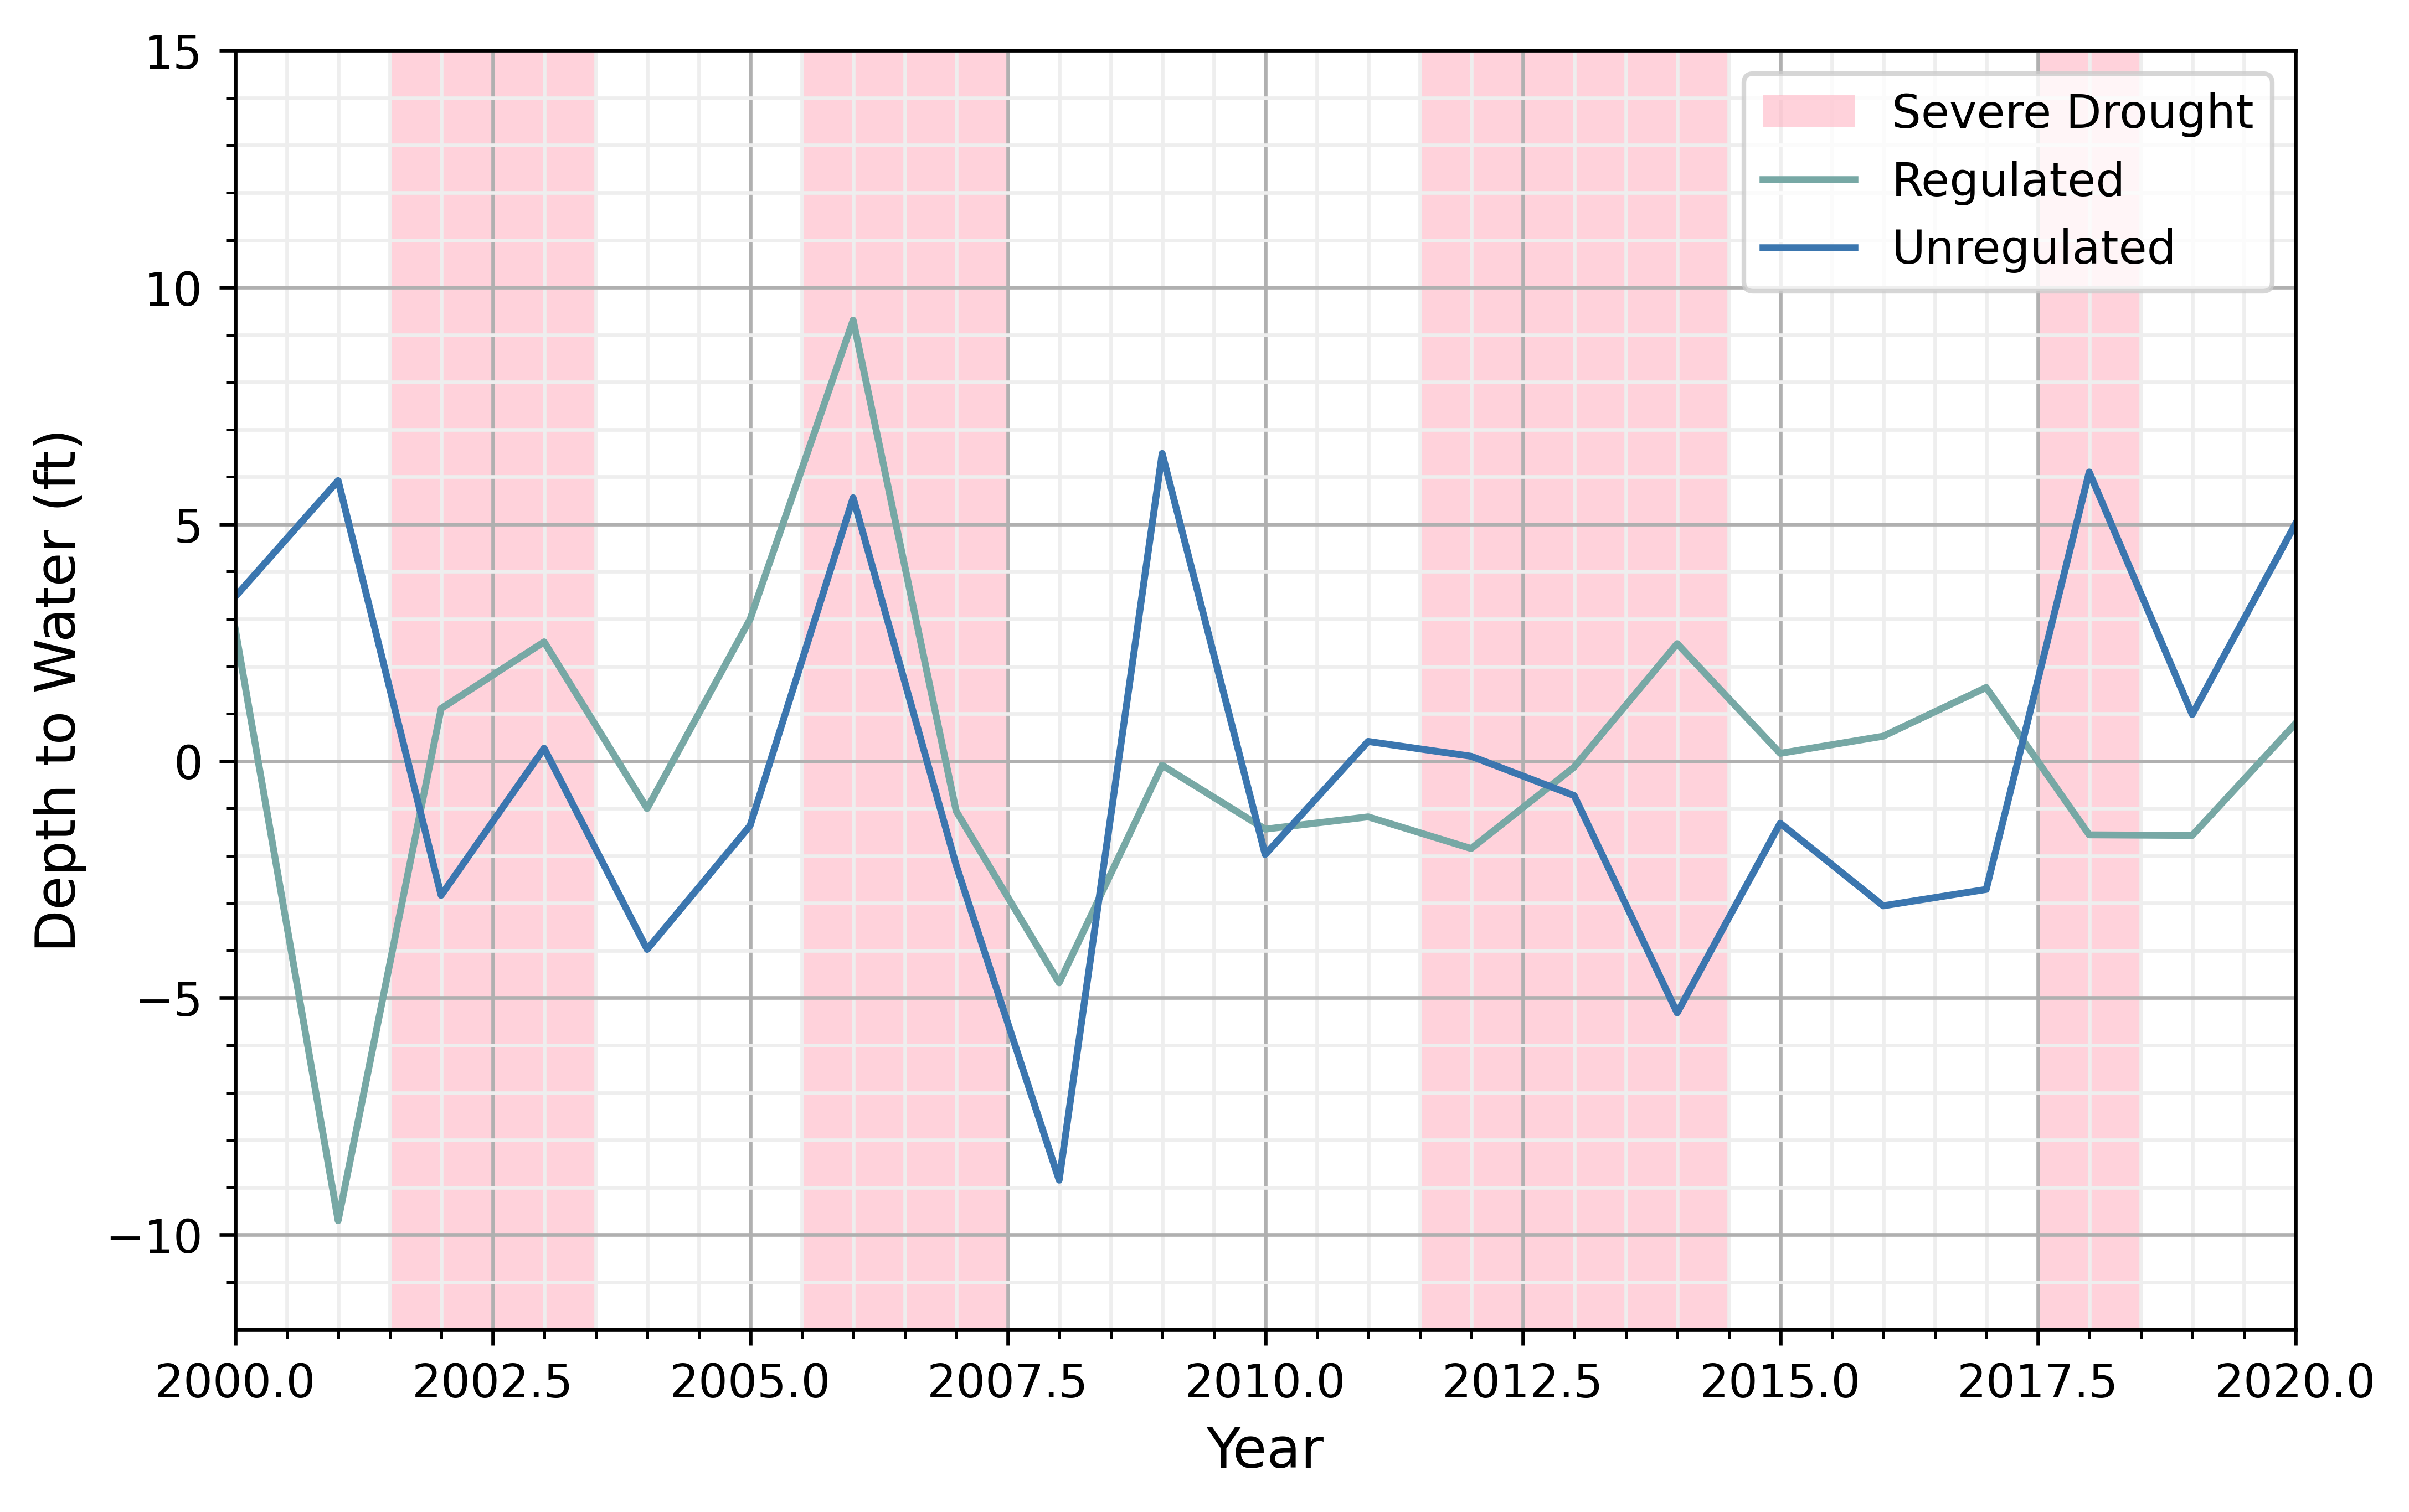

In [234]:
# For Depth to Water by regulation
ds = dtw_anomalys
min_yr = 2000
mx_yr = 2020
betterlabels = ['Regulated','Unregulated'] 

fig, ax = plt.subplots(1, 1, figsize = (8,5))

min_y = -12
max_y = 15
fsize = 12

# Drought Year Shading
a = 1988.5
b = 1990.5
c = 1995.5
d = 1996.5
# e = 1999.5
# f = 2000.5
g = 2001.5
h = 2003.5
i = 2005.5
j = 2007.5
k = 2011.5
l = 2014.5
m = 2017.5
n = 2018.5
plt.axvspan(a, b, color=drought_color, alpha=0.5, lw=0
            , label="Severe Drought"
            )
plt.axvspan(c, d, color=drought_color, alpha=0.5, lw=0)
# plt.axvspan(e, f, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(g, h, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(i, j, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(k, l, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(m, n, color=drought_color, alpha=0.5, lw=0)

ax.plot(ds['R'], label='Regulated', color=cap) 
ax.plot(ds['U'], label='Unregulated', color=GWdom) 

ax.set_xlim(min_yr,mx_yr)
ax.set_ylim(min_y,max_y)
# ax.grid(True)
ax.grid(visible=True,which='major')
ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('Depth to Water (ft)',fontsize=fsize)
ax.minorticks_on()
fig.set_dpi(600.0)
# ax.set_title('a)',loc='left',pad=15)
ax.legend(loc='upper right')

#Putting Grace on a secondary axis
# ax2 = ax.twinx()
# ax2.plot(grace_yearly['0'], label='State Average LWE', color='k',zorder=1)
# ax2.set_ylim([15, -15])
# ax2.set_ylabel(u'Δ LWE (cm)',fontsize=fsize)
# ax2.legend(loc='lower right')

plt.savefig(figurepath+'Timeseries of DTW Anomalies for Regulation', bbox_inches = 'tight')

In [101]:
maxdf = cat_wl2_reg_max[(cat_wl2_reg_max.index>=1975)&(cat_wl2_reg_max.index<=2020)]
mindf = cat_wl2_reg_min[(cat_wl2_reg_min.index>=1975)&(cat_wl2_reg_min.index<=2020)]

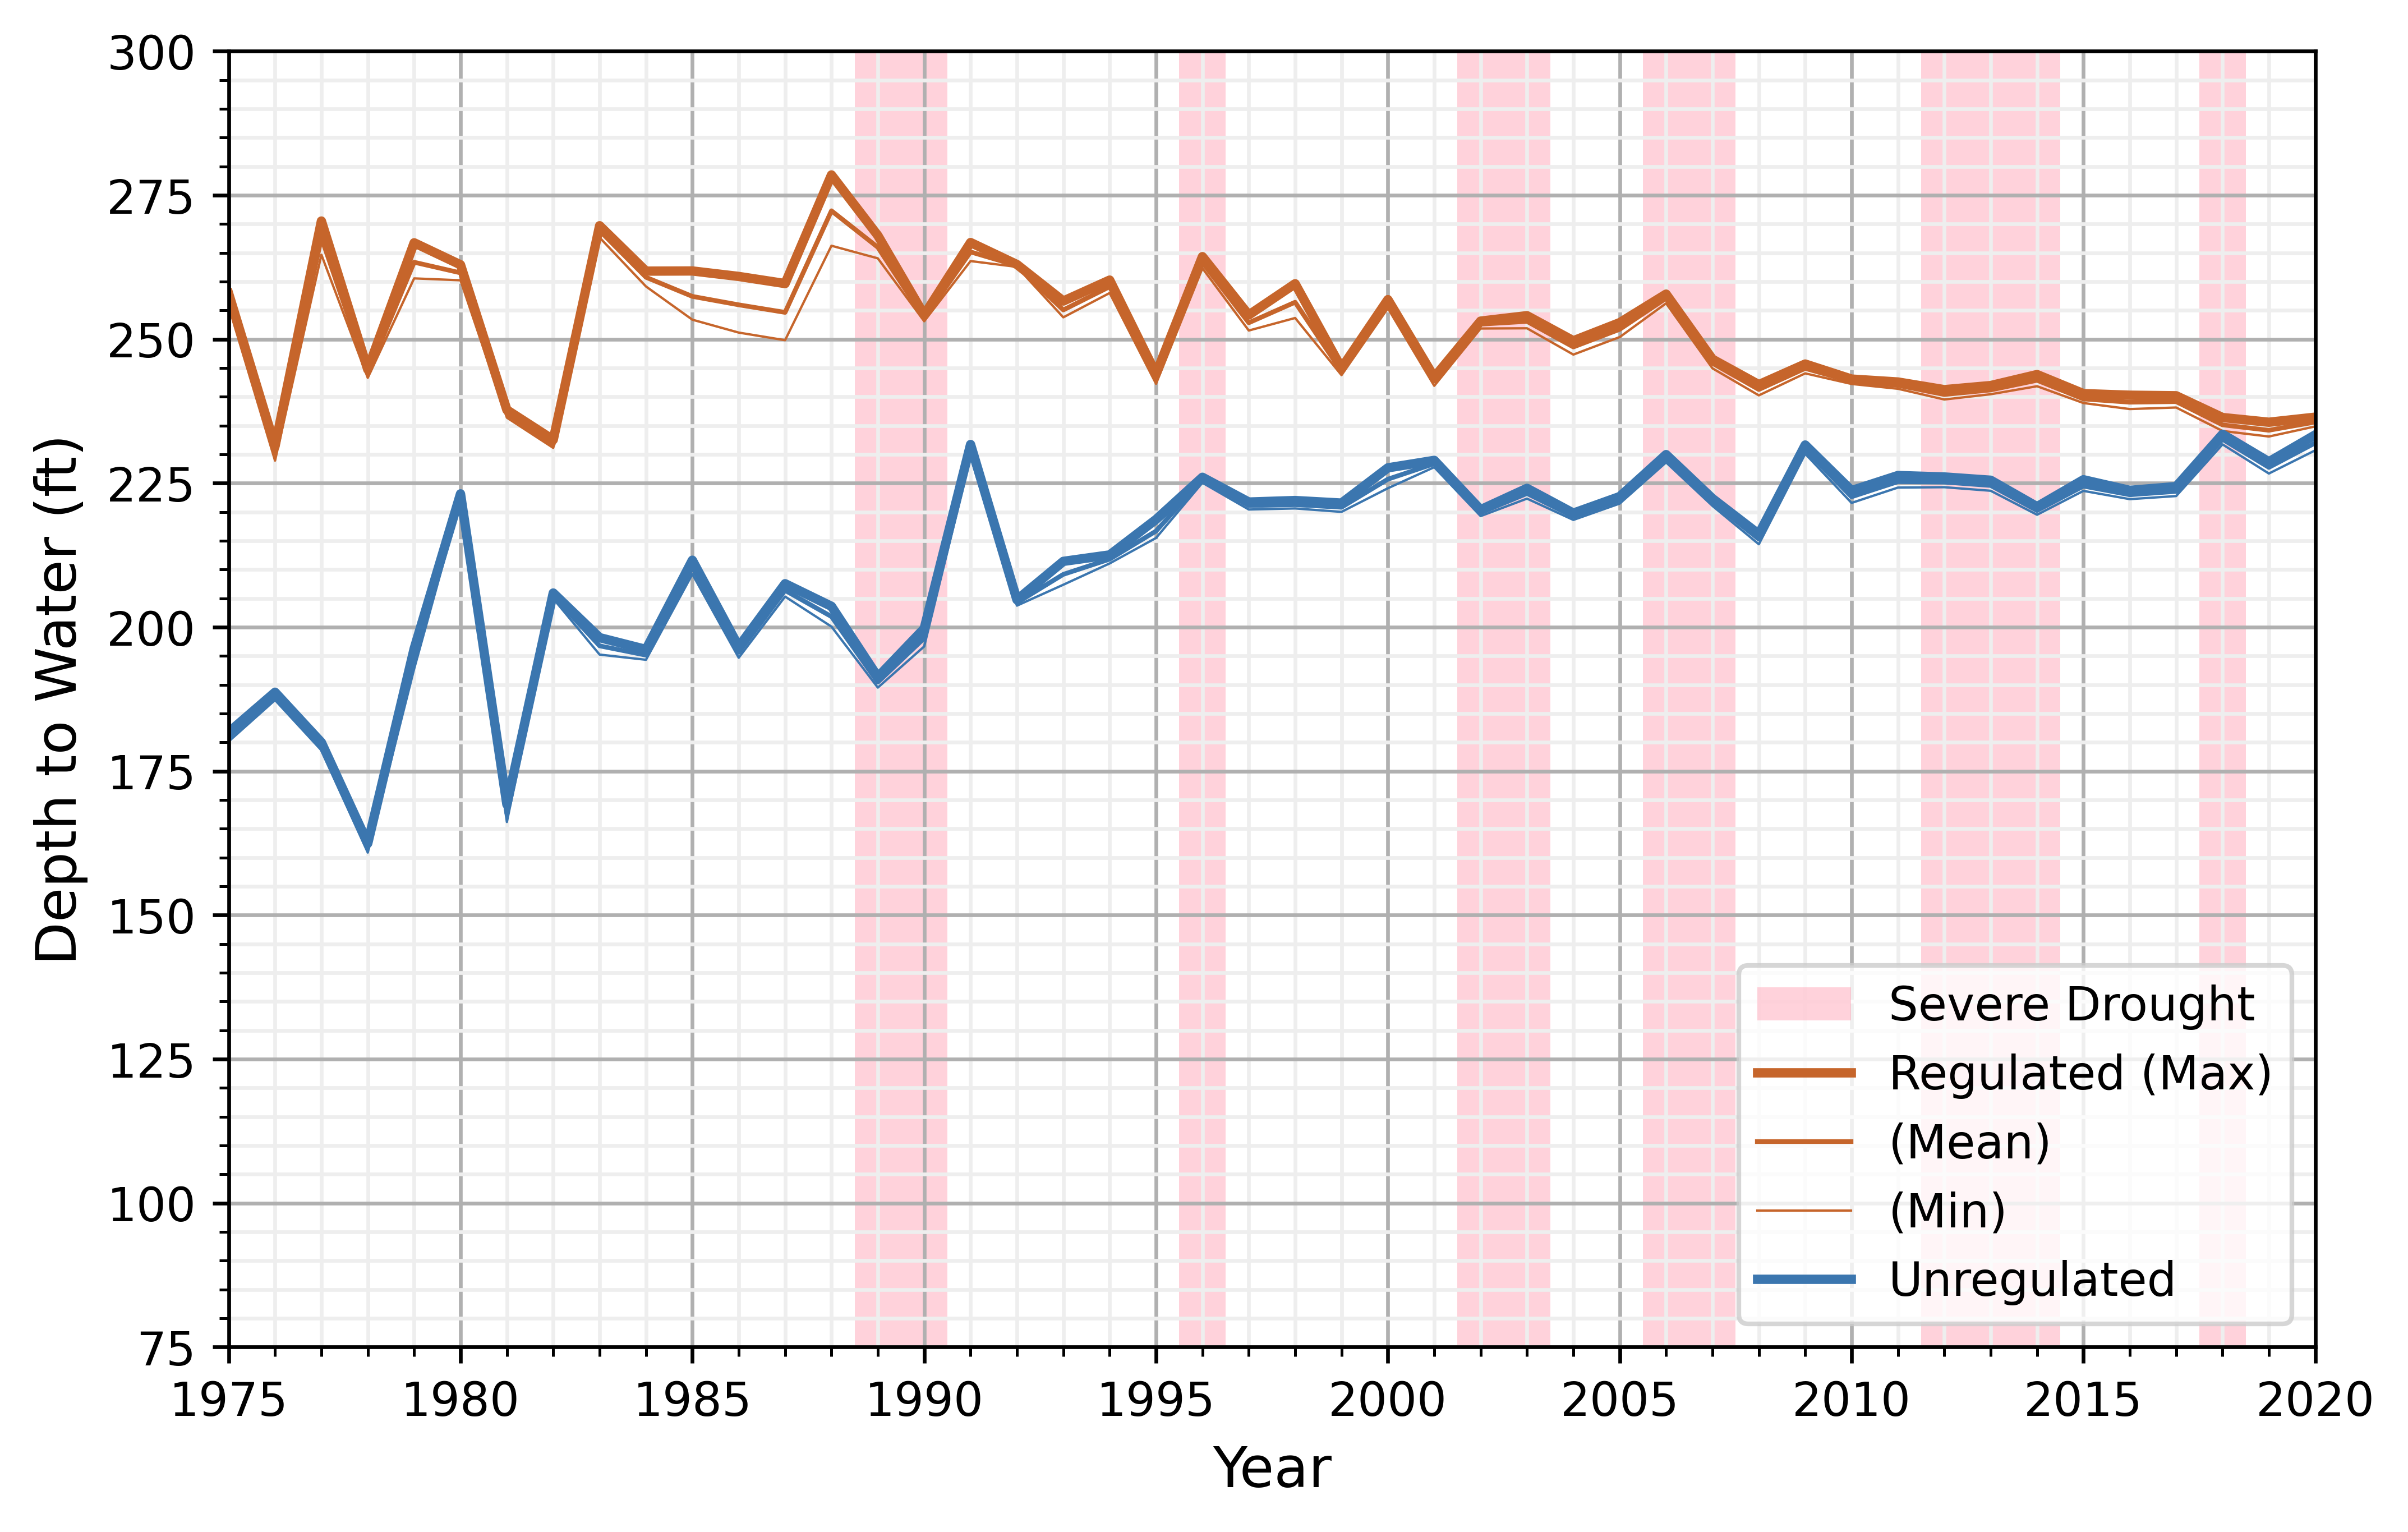

In [104]:
# For Depth to Water by regulation
ds = maxdf
min_yr = 1975
mx_yr = 2020
betterlabels = ['Regulated','Unregulated'] 

fig, ax = plt.subplots(1, 1, figsize = (8,5))

min_y = 75
max_y = 300
fsize = 12

# Drought Year Shading
a = 1988.5
b = 1990.5
c = 1995.5
d = 1996.5
# e = 1999.5
# f = 2000.5
g = 2001.5
h = 2003.5
i = 2005.5
j = 2007.5
k = 2011.5
l = 2014.5
m = 2017.5
n = 2018.5
plt.axvspan(a, b, color=drought_color, alpha=0.5, lw=0
            , label="Severe Drought"
            )
plt.axvspan(c, d, color=drought_color, alpha=0.5, lw=0)
# plt.axvspan(e, f, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(g, h, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(i, j, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(k, l, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(m, n, color=drought_color, alpha=0.5, lw=0)


ax.plot(ds['R'], label='Regulated (Max)', color=cap,lw = 2)
ax.plot(wlanalysis_period['R'], label='(Mean)', color=cap,lw = 1) 
ax.plot(mindf['R'], label='(Min)', color=cap,lw = 0.5)  
ax.plot(ds['U'], label='Unregulated', color=GWdom, lw = 2)
ax.plot(mindf['U'], color=GWdom, lw = 0.5)  
ax.plot(wlanalysis_period['U'], label='', color=GWdom, lw = 1) 

ax.set_xlim(min_yr,mx_yr)
ax.set_ylim(min_y,max_y)
# ax.grid(True)
ax.grid(visible=True,which='major')
ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('Depth to Water (ft)',fontsize=fsize)
ax.minorticks_on()
fig.set_dpi(600.0)
# ax.set_title('a)',loc='left',pad=15)
ax.legend(loc='lower right')

#Putting Grace on a secondary axis
# ax2 = ax.twinx()
# ax2.plot(grace_yearly['0'], label='State Average LWE', color='k',zorder=1)
# ax2.set_ylim([15, -15])
# ax2.set_ylabel(u'Δ LWE (cm)',fontsize=fsize)
# ax2.legend(loc='lower right')

plt.savefig(figurepath+'Timeseries Max versus mean Regulation', bbox_inches = 'tight')

In [42]:
DROUGHT_YEARS

{3: [2002, 2003], 4: [2006, 2007], 5: [2012, 2013, 2014], 6: [2018]}

Calculating Max Drawdown (maximum anomaly in the drought period)

In [183]:
# %% Average Anomalie for drought periods
ds = dtw_anomalys.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


dtw_max_anomalies = ds.groupby(['Status']).max()
dtw_max_anomalies
# ds

R         U
Status                        
Drought 3   2.517005  0.270750
Drought 4   9.309019  5.558563
Drought 5   2.479189  0.101379
Drought 6  -1.557118  6.102082
Normal-Wet  2.997534  6.494348

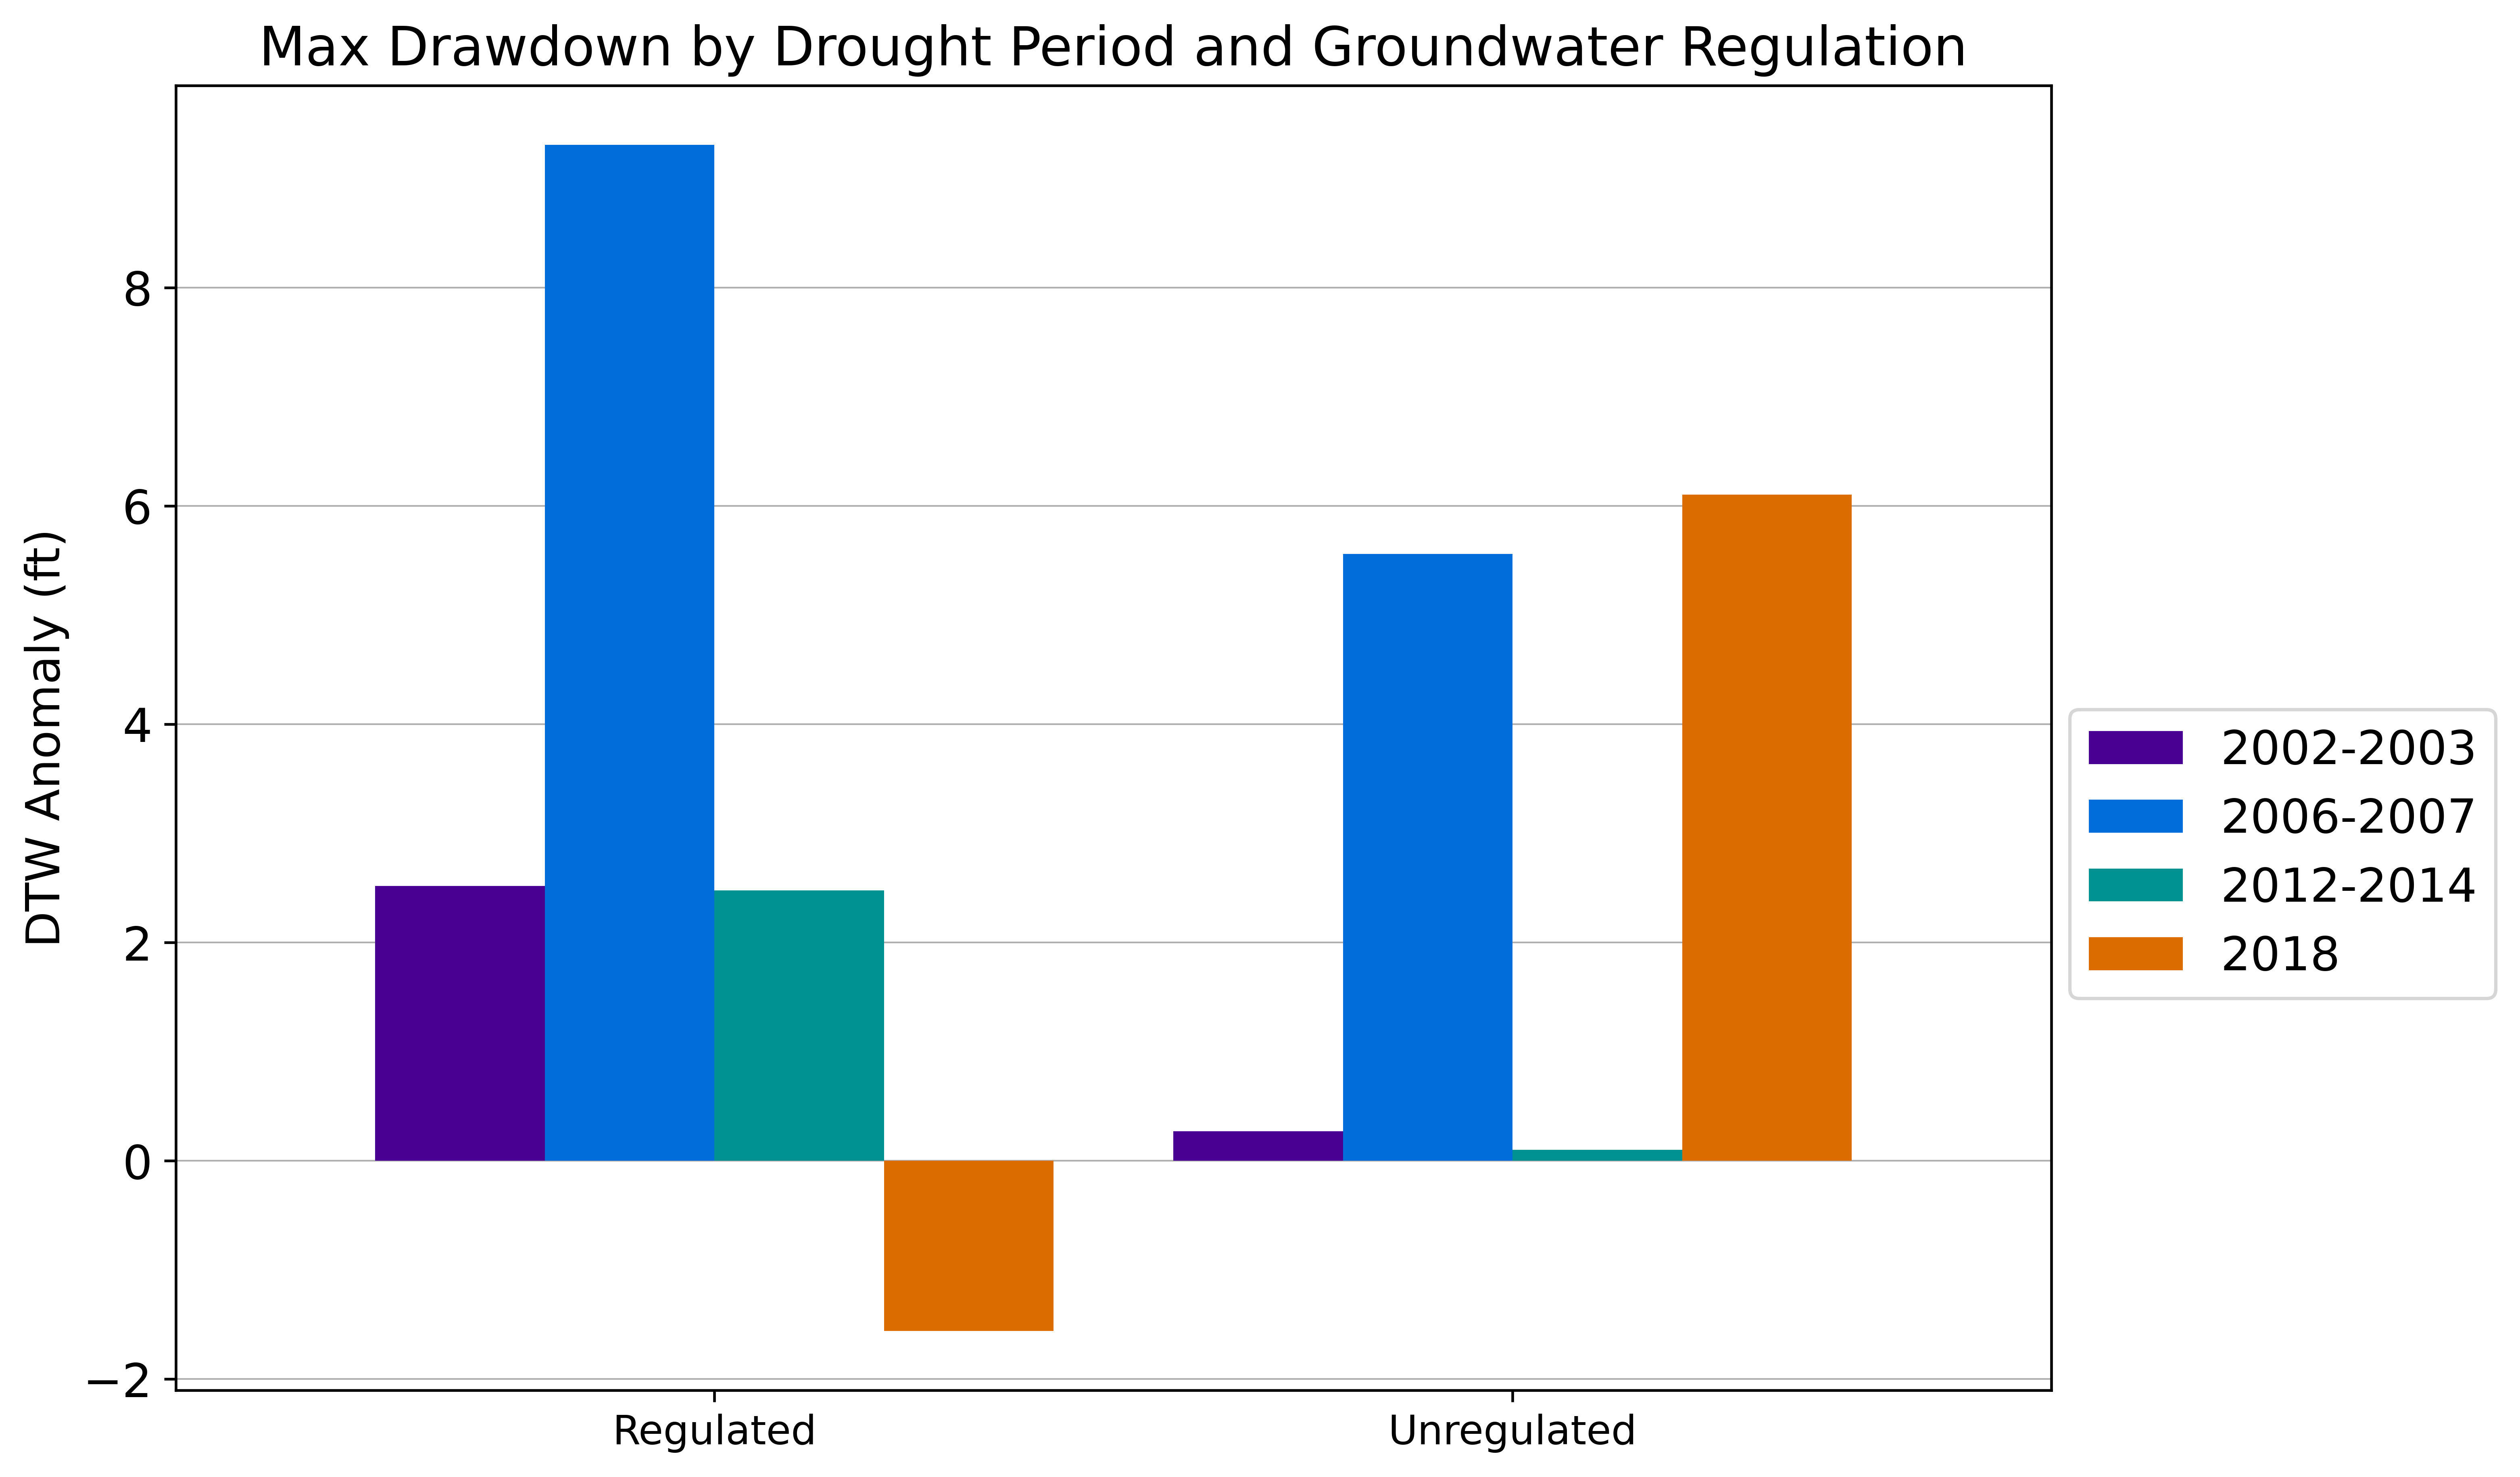

In [184]:
#%% Grouped Bar chart for drawdown (ft)
# name = 'Average DTW Anomalies by Drought Period and Groundwater Regulation'
name = 'Max Drawdown by Drought Period and Groundwater Regulation'

yearlabels = [
                # "1989-1990"
        #       ,'1996',
              '2002-2003','2006-2007','2012-2014','2018'
              ,'Normal/Wet Years'
        ]
# betterlabels = ['CAP','Regulated \n Groundwater','Surface \n Water','Unregulated \n Groundwater','Mixed \n GW/SW'] 
betterlabels = ['Regulated','Unregulated']

dtw_max_anomalies.index = yearlabels
dtw_max_anomalies = dtw_max_anomalies.transpose()

dtw_max_anomalies.index = betterlabels
del dtw_max_anomalies['Normal/Wet Years']
dtw_max_anomalies


# group_colors = ['lightsalmon','tomato','orangered','r','brown','indianred','steelblue']

group_colors = [blind[5],blind[6],blind[2]
                ,blind[12],blind[11],blind[10]
                # ,blind[0] #black
                ]

horlabel = 'DTW Anomaly (ft)'
fsize = 14

plt.rcParams["figure.dpi"] = 600
dtw_max_anomalies.plot(figsize = (10,7),
        kind='bar',
        stacked=False,
        # title=name,
        color = group_colors,
        zorder = 2,
        width = 0.85,
        fontsize = fsize
        )
plt.title(name, fontsize = (fsize+2))
# plt.ylim([0,400])
plt.ylabel(horlabel, fontsize = fsize)
plt.xticks(rotation=0, fontsize = fsize-2)
plt.grid(axis='y', linewidth=0.5, zorder=0)
plt.legend(loc=[1.01,0.3],fontsize = fsize)
# plt.set_dpi(600)

plt.savefig(figurepath+name+'_groupedchart', bbox_inches = 'tight')
# plt.savefig(outputpath+name+'_anomalies_SWAccess_groupedchart', bbox_inches = 'tight')

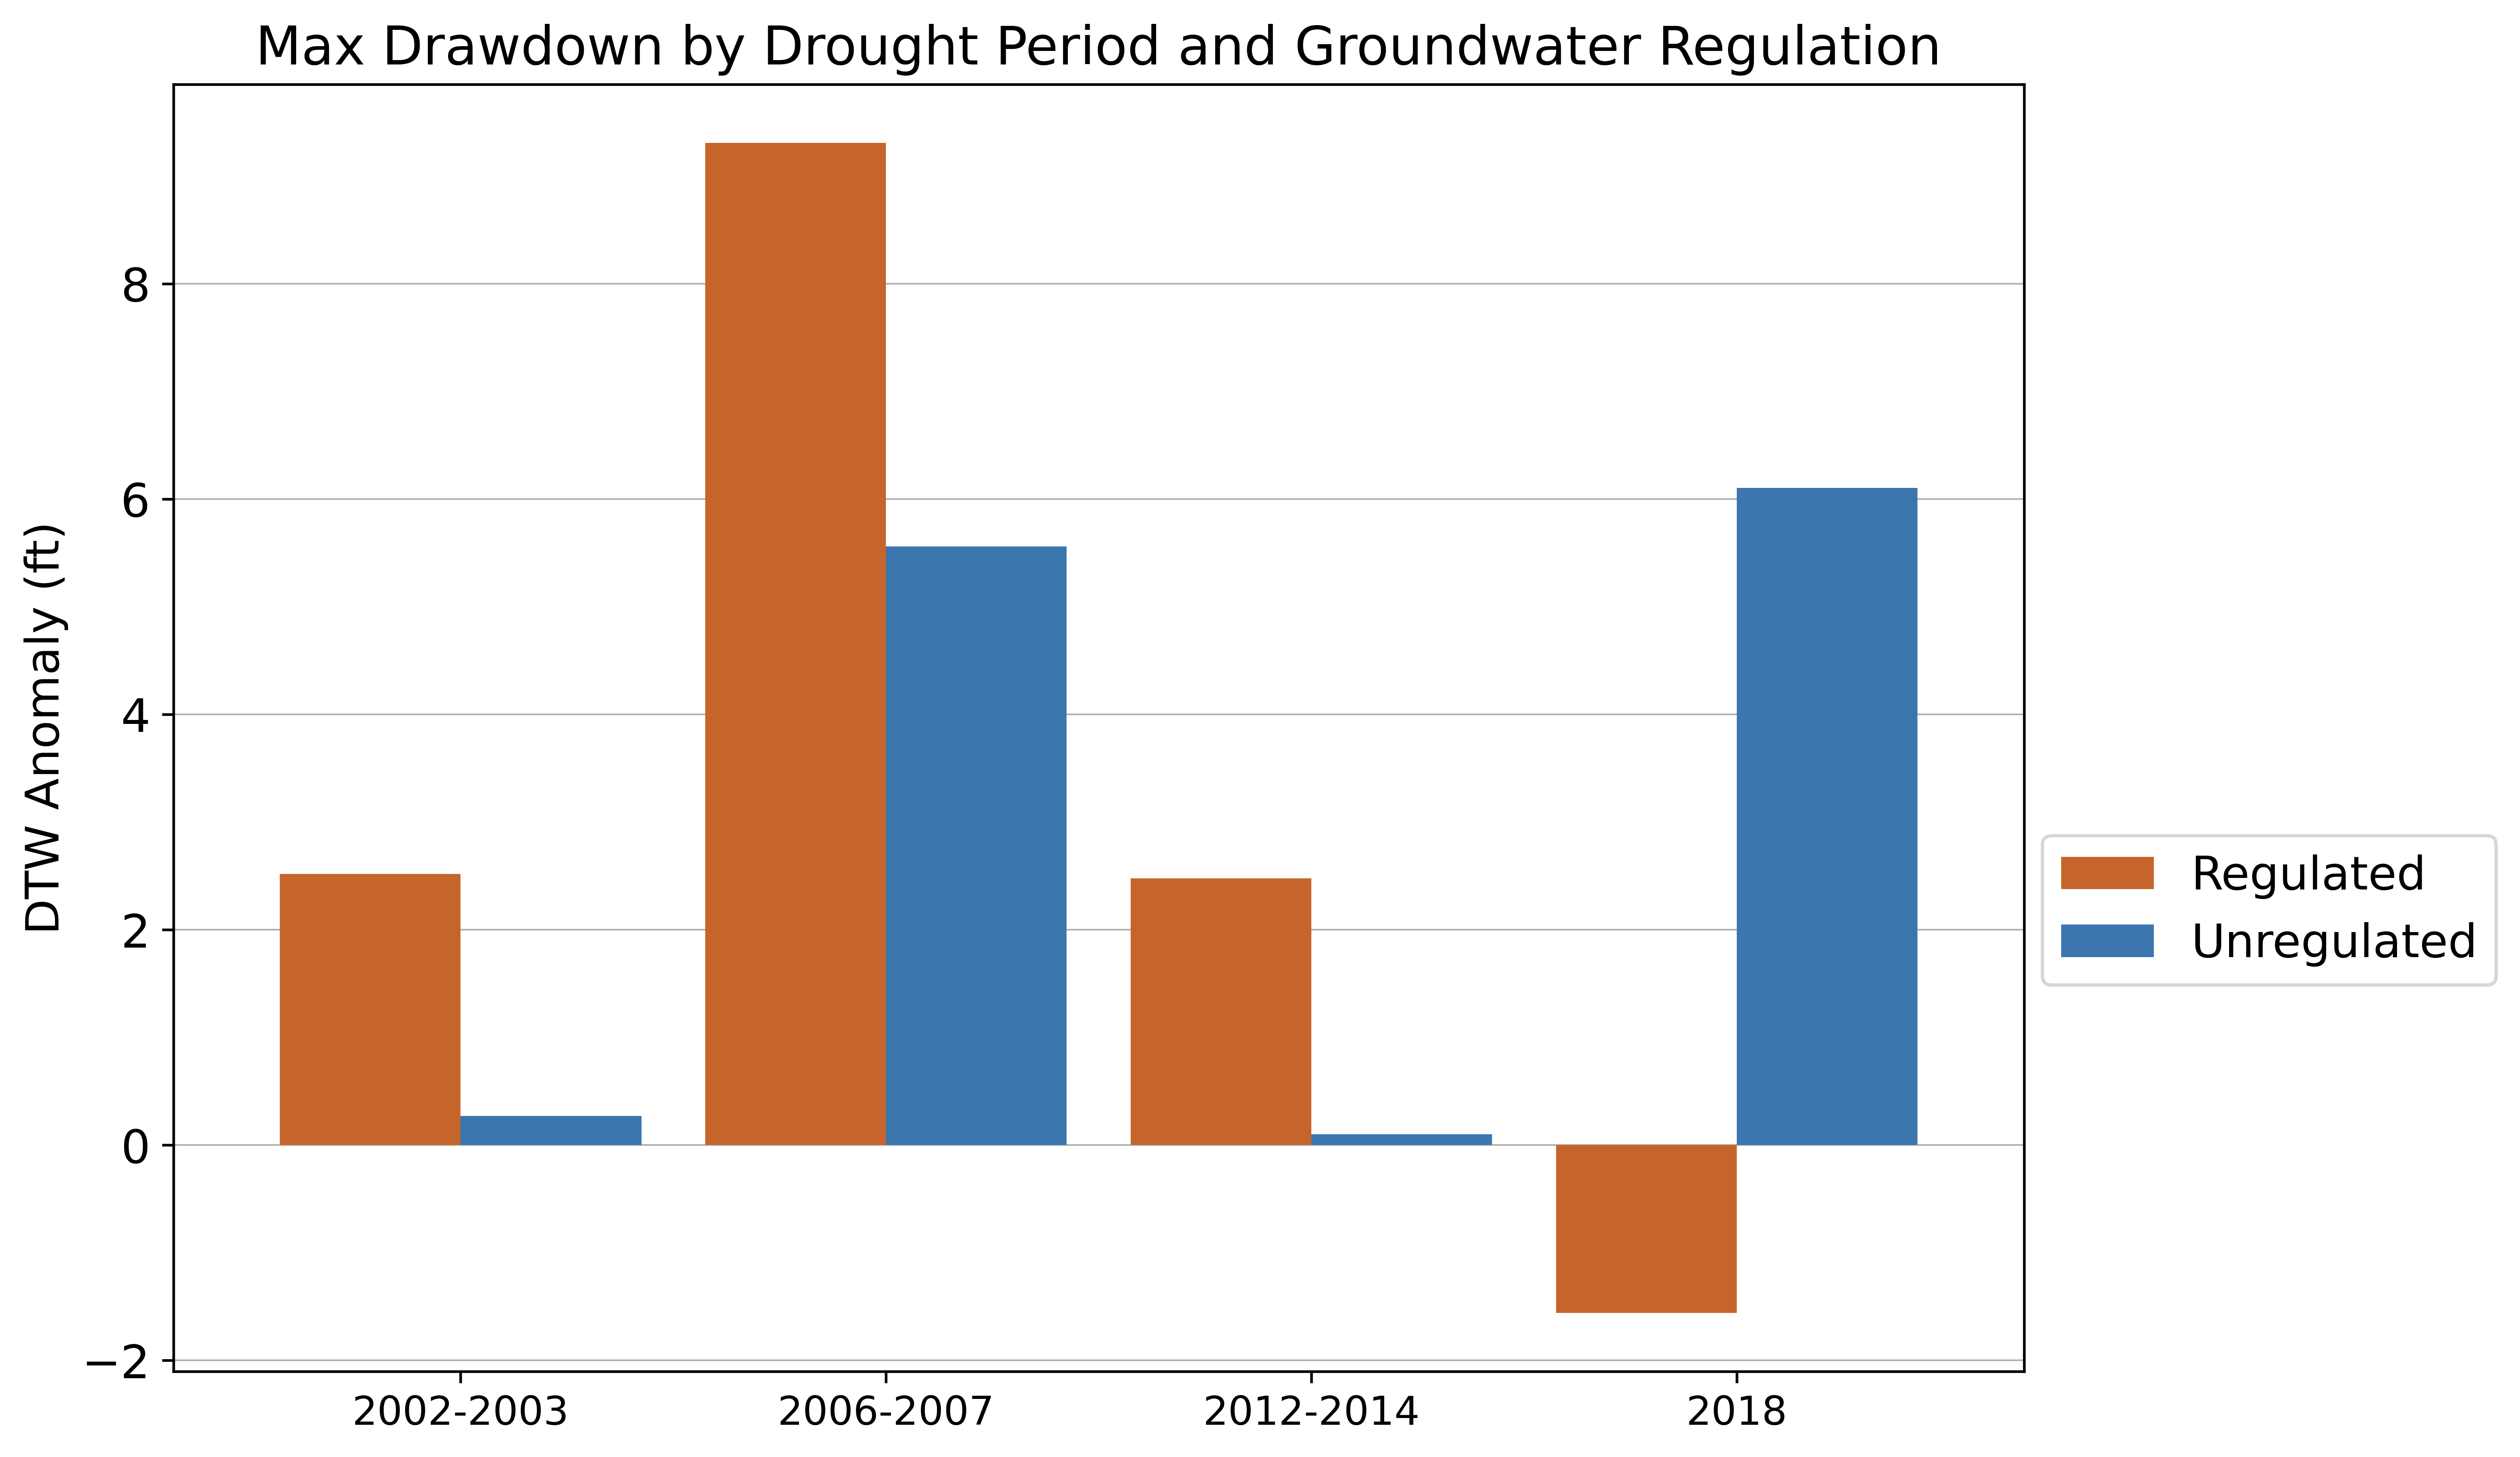

In [185]:
#%% Grouped Bar chart for drawdown (ft)
# name = 'Average DTW Anomalies by Drought Period and Groundwater Regulation'
name = 'Max Drawdown by Drought Period and Groundwater Regulation'

dtw_max_anomalies = dtw_max_anomalies.transpose()


# group_colors = ['lightsalmon','tomato','orangered','r','brown','indianred','steelblue']

# group_colors = [blind[5],blind[6],blind[2]
#                 ,blind[12],blind[11],blind[10]
#                 # ,blind[0] #black
#                 ]
group_colors = [cap,GWdom]

horlabel = 'DTW Anomaly (ft)'
fsize = 14

plt.rcParams["figure.dpi"] = 600
dtw_max_anomalies.plot(figsize = (10,7),
        kind='bar',
        stacked=False,
        # title=name,
        color = group_colors,
        zorder = 2,
        width = 0.85,
        fontsize = fsize
        )
plt.title(name, fontsize = (fsize+2))
# plt.ylim([0,400])
plt.ylabel(horlabel, fontsize = fsize)
plt.xticks(rotation=0, fontsize = fsize-2)
plt.grid(axis='y', linewidth=0.5, zorder=0)
plt.legend(loc=[1.01,0.3],fontsize = fsize)
# plt.set_dpi(600)

plt.savefig(figurepath+name+'_groupedchart_transposed', bbox_inches = 'tight')
# plt.savefig(outputpath+name+'_anomalies_SWAccess_groupedchart', bbox_inches = 'tight')

### For Access to Surface Water

In [235]:
cat_wl2 = cat_wl2_SW.copy()

wlanalysis_period = cat_wl2[(cat_wl2.index>=Min_year_of_Study)&(cat_wl2.index<=2020)]
del wlanalysis_period['Res']
del wlanalysis_period['Mix']
wlanalysis_period.head()

CAP          GW      No_CAP          SW
index                                                
2000   273.173392  230.186217  168.681240  100.654375
2001   253.869492  230.362615  177.777013   59.665000
2002   262.944658  221.268065  190.441211   77.343500
2003   266.064568  227.347577  184.761768   79.540393
2004   260.522958  224.650653  186.223160   84.221469

Reformatting the table so it's in the right order

In [236]:
blank = pd.DataFrame()
blank['SW'] = wlanalysis_period['SW']
blank['CAP'] = wlanalysis_period['CAP']
blank['GW'] = wlanalysis_period['GW']
blank['No_CAP'] = wlanalysis_period['No_CAP']
wlanalysis_period = blank

In [237]:
betterlabels = ['Local Co River'
                ,'CAP Co River'
                ,'Groundwater (Unregulated)'
                ,'Groundwater (Regulated)'
                ]

colors=[swdom
        ,cap
        , GWdom
        , mixed
        ]

For comparing to drought indices

In [238]:
# Some functions since it's not pulling from cf
def kendall_pval(x,y):
        return kendalltau(x,y)[1]
    
def pearsonr_pval(x,y):
        return pearsonr(x,y)[1]
    
def spearmanr_pval(x,y):
        return spearmanr(x,y)[1]

In [239]:

# %% If running a shifted correlation analysis,
#    change this to however many # years; 0 is no lag
lag = 0

ds = wlanalysis_period
columns = ds.columns
column_list = ds.columns.tolist()

print('Kendall Correlation coefficient')
for i in column_list:
        # print(' '+i+':')
        print(' '+str(i)+':')
# To normalize the data 
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices.PDSI.shift(lag)
        print('  tau = ',round(df1.corr(df2, method='kendall'),3))
        print('  pval = ',round(df1.corr(df2, method=kendall_pval),4))

# %%
print('Spearman Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices.PDSI.shift(lag)
        print('  rho = ',round(df1.corr(df2, method='spearman'),3))
        print('  pval = ',round(df1.corr(df2, method=spearmanr_pval),4))

# %%
print('Pearson Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices.PDSI.shift(lag)
        r = df1.corr(df2, method='pearson')
        print('  rsq = ',round(r*r,3))
        print('  pval = ',round(df1.corr(df2, method=pearsonr_pval),4))

Kendall Correlation coefficient
 SW:
  tau =  0.171
  pval =  0.2945
 CAP:
  tau =  -0.171
  pval =  0.2945
 GW:
  tau =  0.057
  pval =  0.7429
 No_CAP:
  tau =  -0.238
  pval =  0.1403
Spearman Correlation coefficient
 SW:
  rho =  0.23
  pval =  0.3161
 CAP:
  rho =  -0.27
  pval =  0.2363
 GW:
  rho =  0.057
  pval =  0.8057
 No_CAP:
  rho =  -0.344
  pval =  0.1266
Pearson Correlation coefficient
 SW:
  rsq =  0.009
  pval =  0.679
 CAP:
  rsq =  0.069
  pval =  0.2505
 GW:
  rsq =  0.009
  pval =  0.6808
 No_CAP:
  rsq =  0.162
  pval =  0.0704


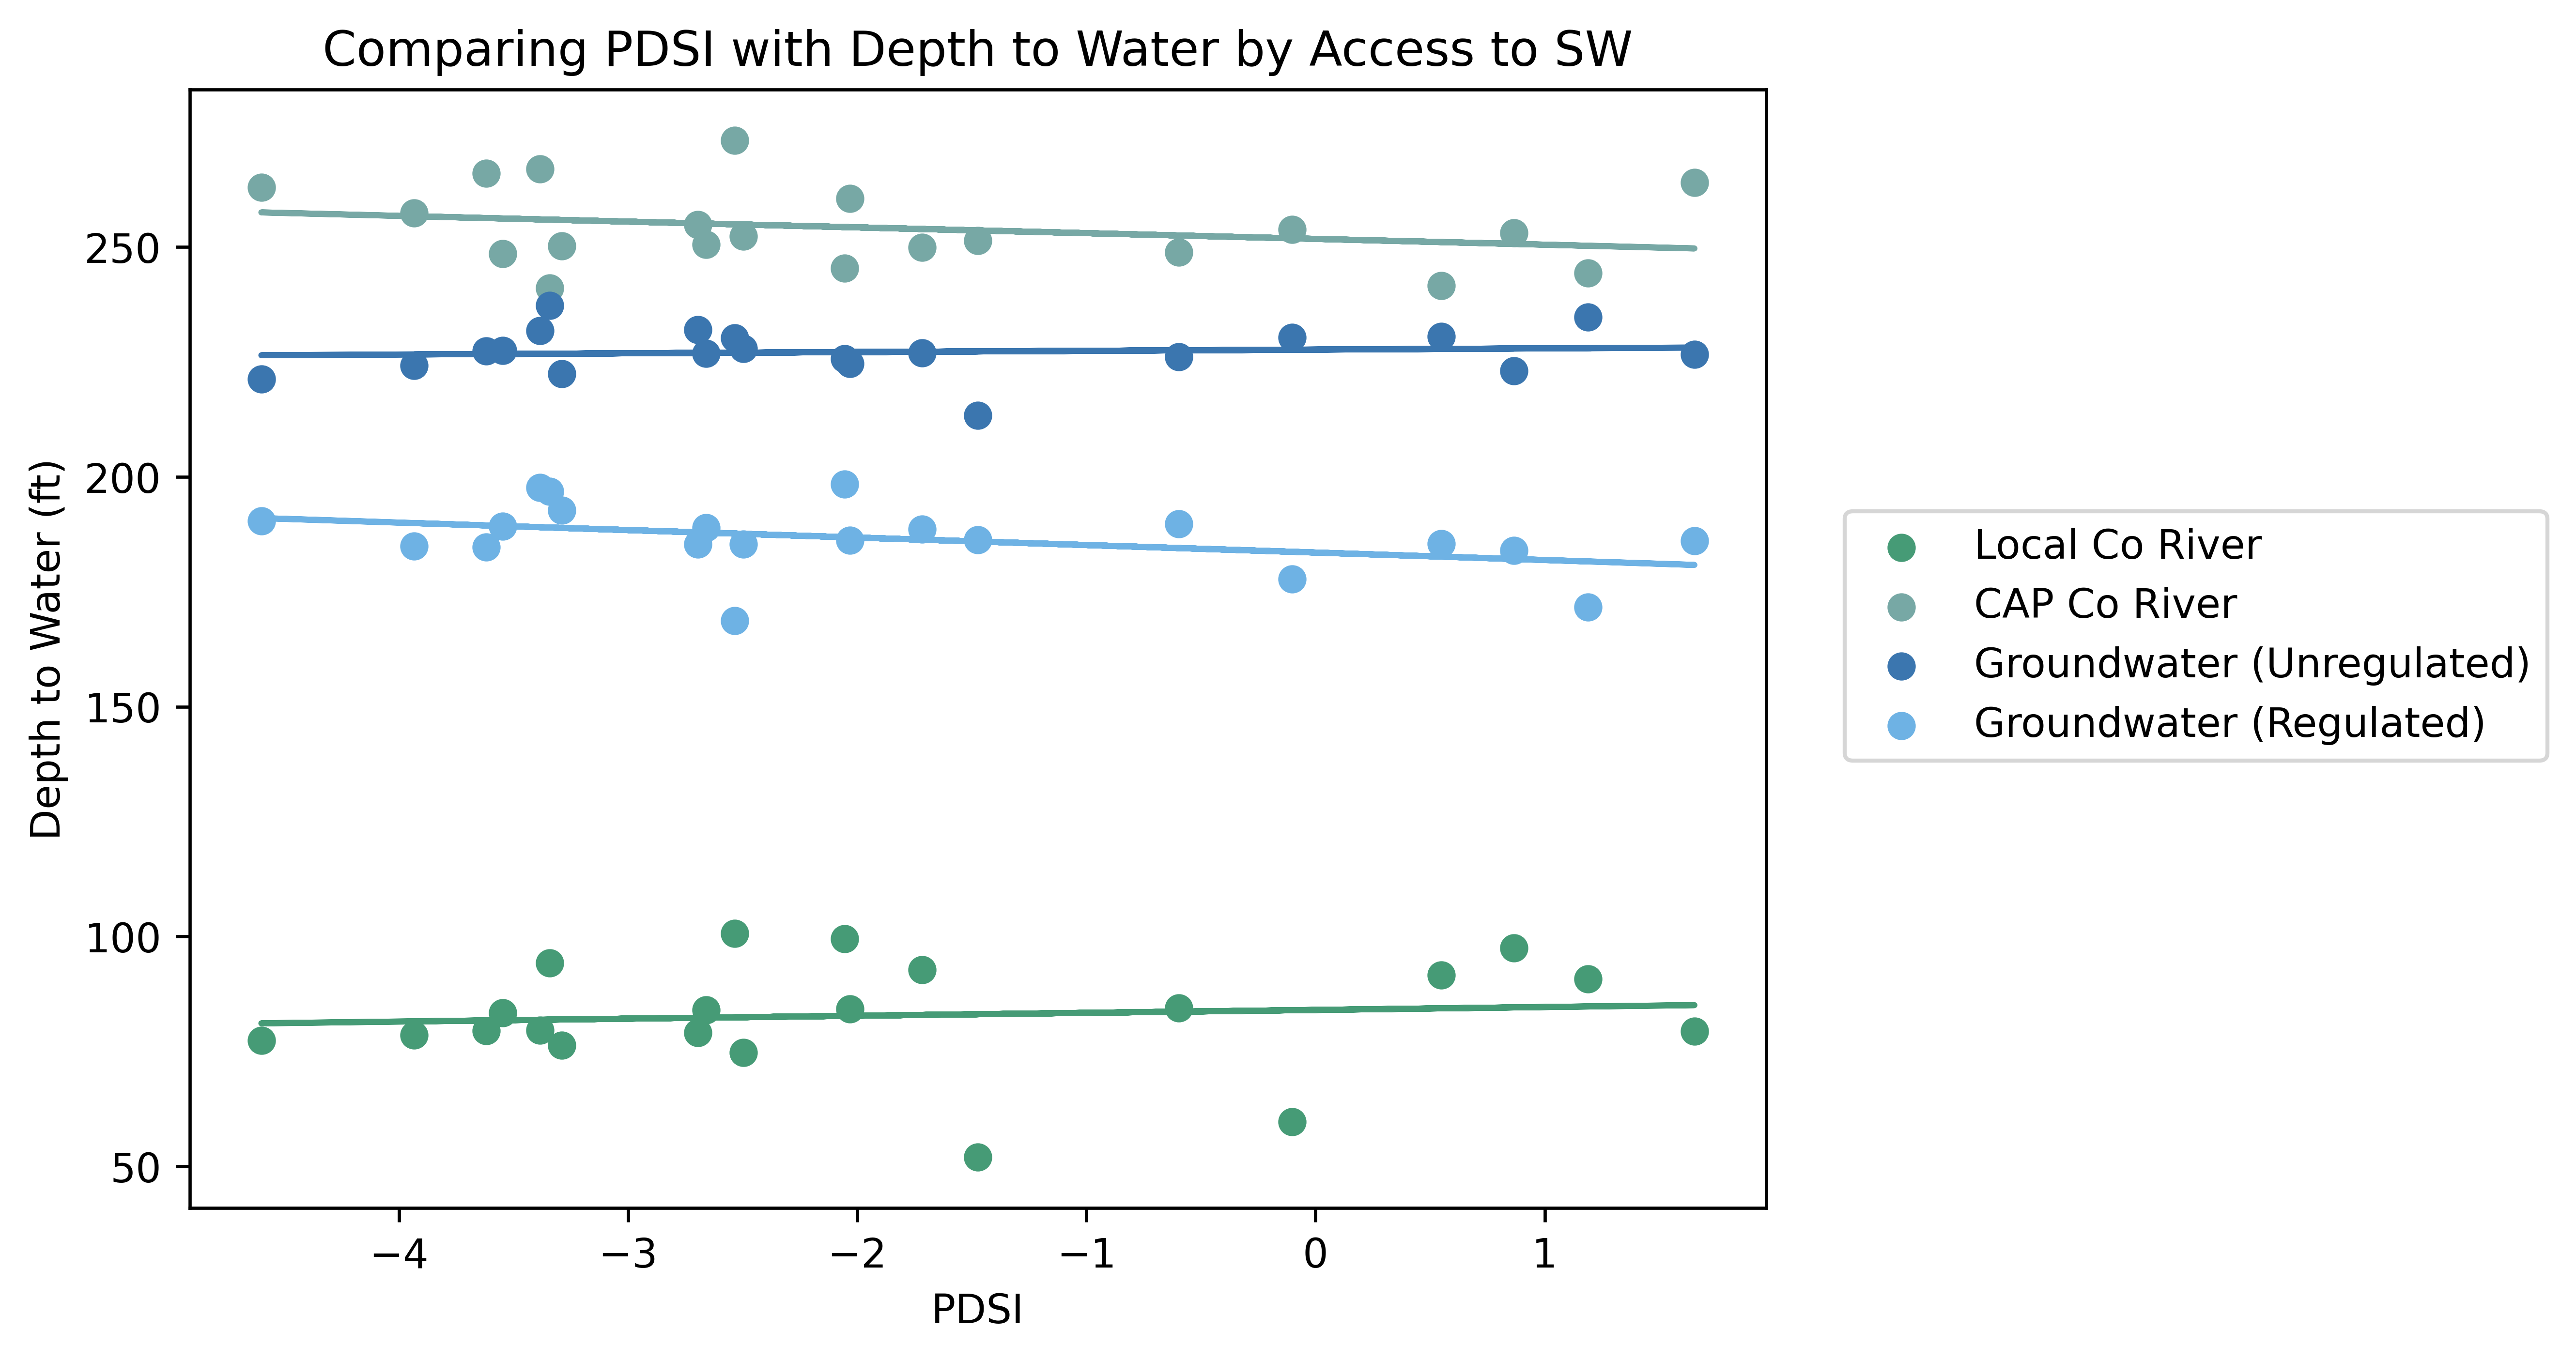

In [240]:
# %% Scatterplot of correlation values
ds = wlanalysis_period
name = 'Comparing PDSI with Depth to Water by Access to SW'
# name = 'Comparing PDSI with Depth to Water by Regulation'
# del ds['Res']
columns = ds.columns
column_list = ds.columns.tolist()

fig, ax = plt.subplots(figsize = (7,5))
x = drought_indices['PDSI']
for i,j,k in zip(column_list
                # ,reg_colors
                # , SW_colors
                , colors
                , betterlabels
                ):
        y = ds[i]
        ax.scatter(x,y
                , label=k
                , color=j
                )
        # Trendline: 1=Linear, 2=polynomial
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        plt.plot(x, p(x),'-'
                , color=j
                # ,label=(k+' Trendline')
                )


ax.set_xlabel('PDSI')
ax.set_ylabel('Depth to Water (ft)')
ax.set_title(name,loc='center')
# ax.set_ylim(0,400)
fig.set_dpi(600)
plt.legend(loc = [1.05, 0.40])

plt.savefig(outputpath+name, bbox_inches='tight') 

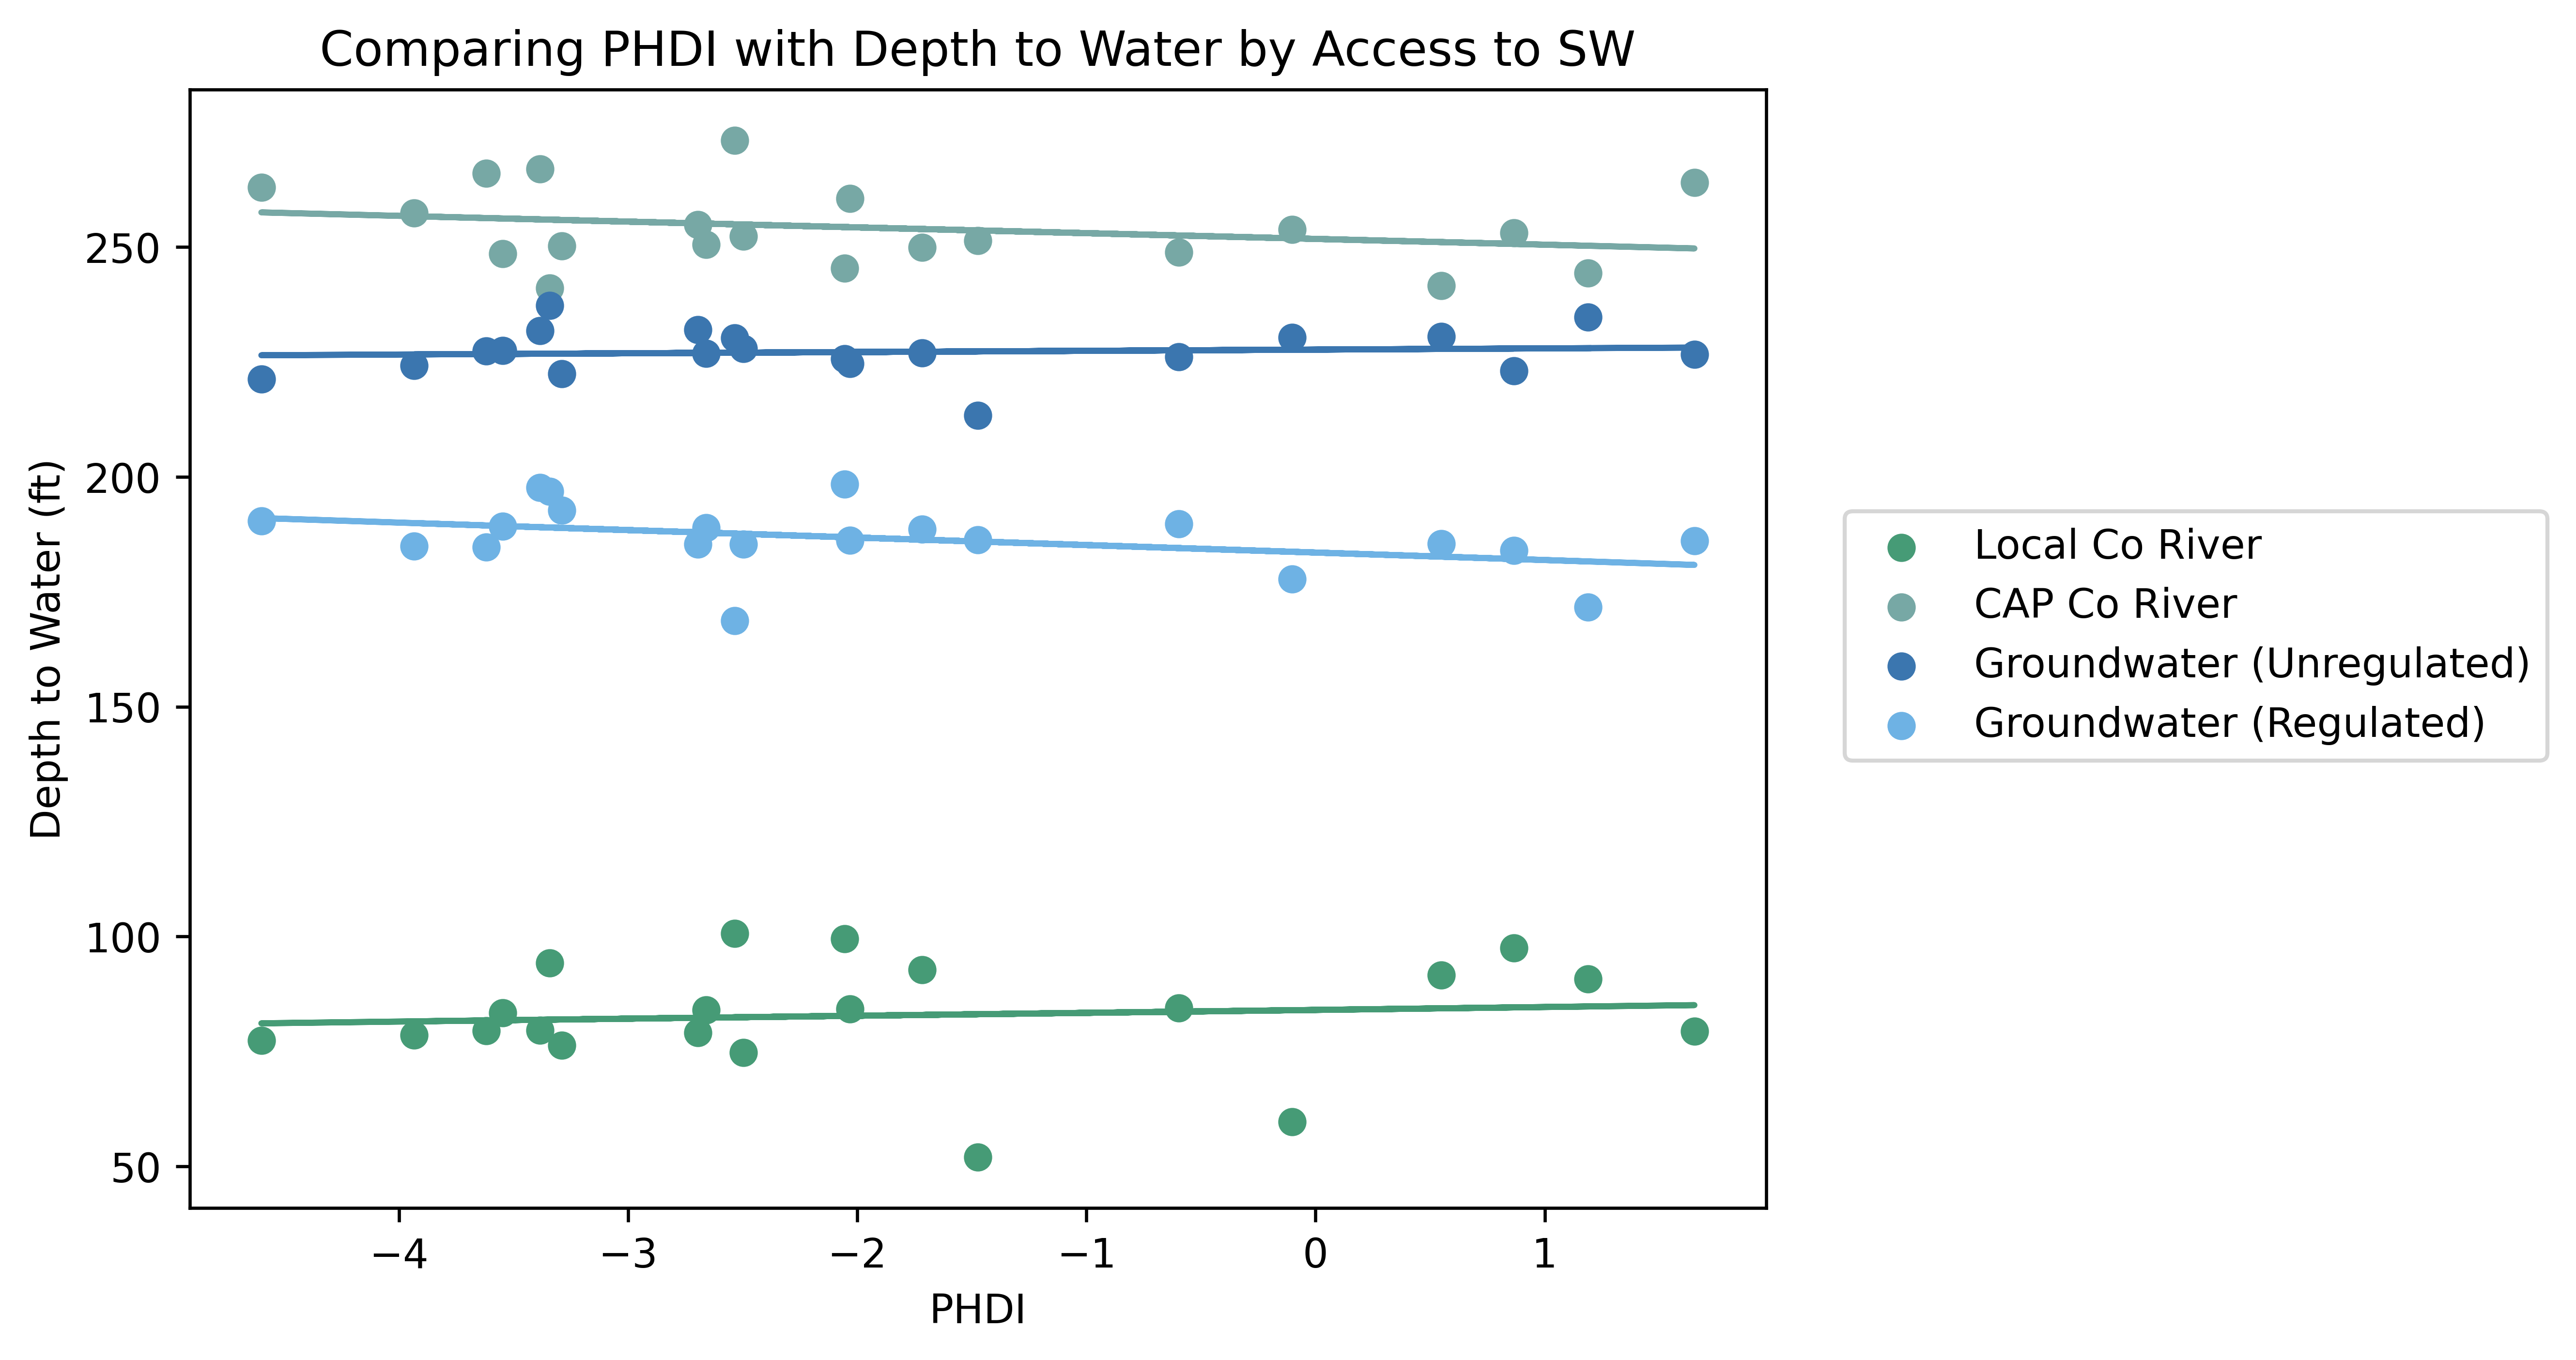

In [241]:
# %% Scatterplot of correlation values
ds = wlanalysis_period
name = 'Comparing PHDI with Depth to Water by Access to SW'
# name = 'Comparing PDSI with Depth to Water by Regulation'
# del ds['Res']
columns = ds.columns
column_list = ds.columns.tolist()

fig, ax = plt.subplots(figsize = (7,5))
x = drought_indices['PDSI']
for i,j,k in zip(column_list
                # ,reg_colors
                # , SW_colors
                , colors
                , betterlabels
                ):
        y = ds[i]
        ax.scatter(x,y
                , label=k
                , color=j
                )
        # Trendline: 1=Linear, 2=polynomial
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        plt.plot(x, p(x),'-'
                , color=j
                # ,label=(k+' Trendline')
                )


ax.set_xlabel('PHDI')
ax.set_ylabel('Depth to Water (ft)')
ax.set_title(name,loc='center')
# ax.set_ylim(0,400)
fig.set_dpi(600)
plt.legend(loc = [1.05, 0.40])

plt.savefig(outputpath+name, bbox_inches='tight') 

In [242]:
# 1. Anomaly's
ds = wlanalysis_period.copy()
columns = ds.columns
column_list = ds.columns.tolist()

dtw_anomalys = pd.DataFrame()
for i in column_list:
        # Subtracting against the mean
        # dtw_anomalys[i] = wlanalysis_period[i] - wlanalysis_period[i].mean()
        
        # Subtracting against the slope
        df = ds[i]
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err = sp.linregress(x,y)
        # print(y)
        # slope, intercept = sp.linregress(x,y) 
        # dtw_anomalys[i] = wlanalysis_period[i] - ((wlanalysis_period.index*slope) + intercept)
        trend_df[i] = (wlanalysis_period.index*slope) + intercept
        dtw_anomalys[i] = wlanalysis_period[i] - trend_df[i]

dtw_anomalys.head()


SW        CAP        GW     No_CAP
index                                           
2000   25.564871   6.699278  5.209360 -14.483335
2001  -16.199283 -11.372921  5.164417  -5.734665
2002    0.704437  -1.066055 -4.151476   6.582429
2003    2.126550   3.285556  1.706694   0.555882
2004    6.032846  -1.024353 -1.211571   1.670171

In [243]:

# %% If running a shifted correlation analysis,
#    change this to however many # years; 0 is no lag
lag = 0

ds = dtw_anomalys
columns = ds.columns
column_list = ds.columns.tolist()

print('Kendall Correlation coefficient')
for i in column_list:
        # print(' '+i+':')
        print(' '+str(i)+':')
# To normalize the data 
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices.PDSI.shift(lag)
        print('  tau = ',round(df1.corr(df2, method='kendall'),3))
        print('  pval = ',round(df1.corr(df2, method=kendall_pval),4))

# %%
print('Spearman Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices.PDSI.shift(lag)
        print('  rho = ',round(df1.corr(df2, method='spearman'),3))
        print('  pval = ',round(df1.corr(df2, method=spearmanr_pval),4))

# %%
print('Pearson Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought_indices.PDSI.shift(lag)
        r = df1.corr(df2, method='pearson')
        print('  rsq = ',round(r*r,3))
        print('  pval = ',round(df1.corr(df2, method=pearsonr_pval),4))

Kendall Correlation coefficient
 SW:
  tau =  0.019
  pval =  0.9287
 CAP:
  tau =  -0.057
  pval =  0.7429
 GW:
  tau =  0.0
  pval =  1.0
 No_CAP:
  tau =  -0.352
  pval =  0.0262
Spearman Correlation coefficient
 SW:
  rho =  0.053
  pval =  0.8187
 CAP:
  rho =  -0.068
  pval =  0.7712
 GW:
  rho =  0.025
  pval =  0.9154
 No_CAP:
  rho =  -0.504
  pval =  0.0199
Pearson Correlation coefficient
 SW:
  rsq =  0.0
  pval =  0.992
 CAP:
  rsq =  0.01
  pval =  0.6699
 GW:
  rsq =  0.001
  pval =  0.8957
 No_CAP:
  rsq =  0.246
  pval =  0.0223


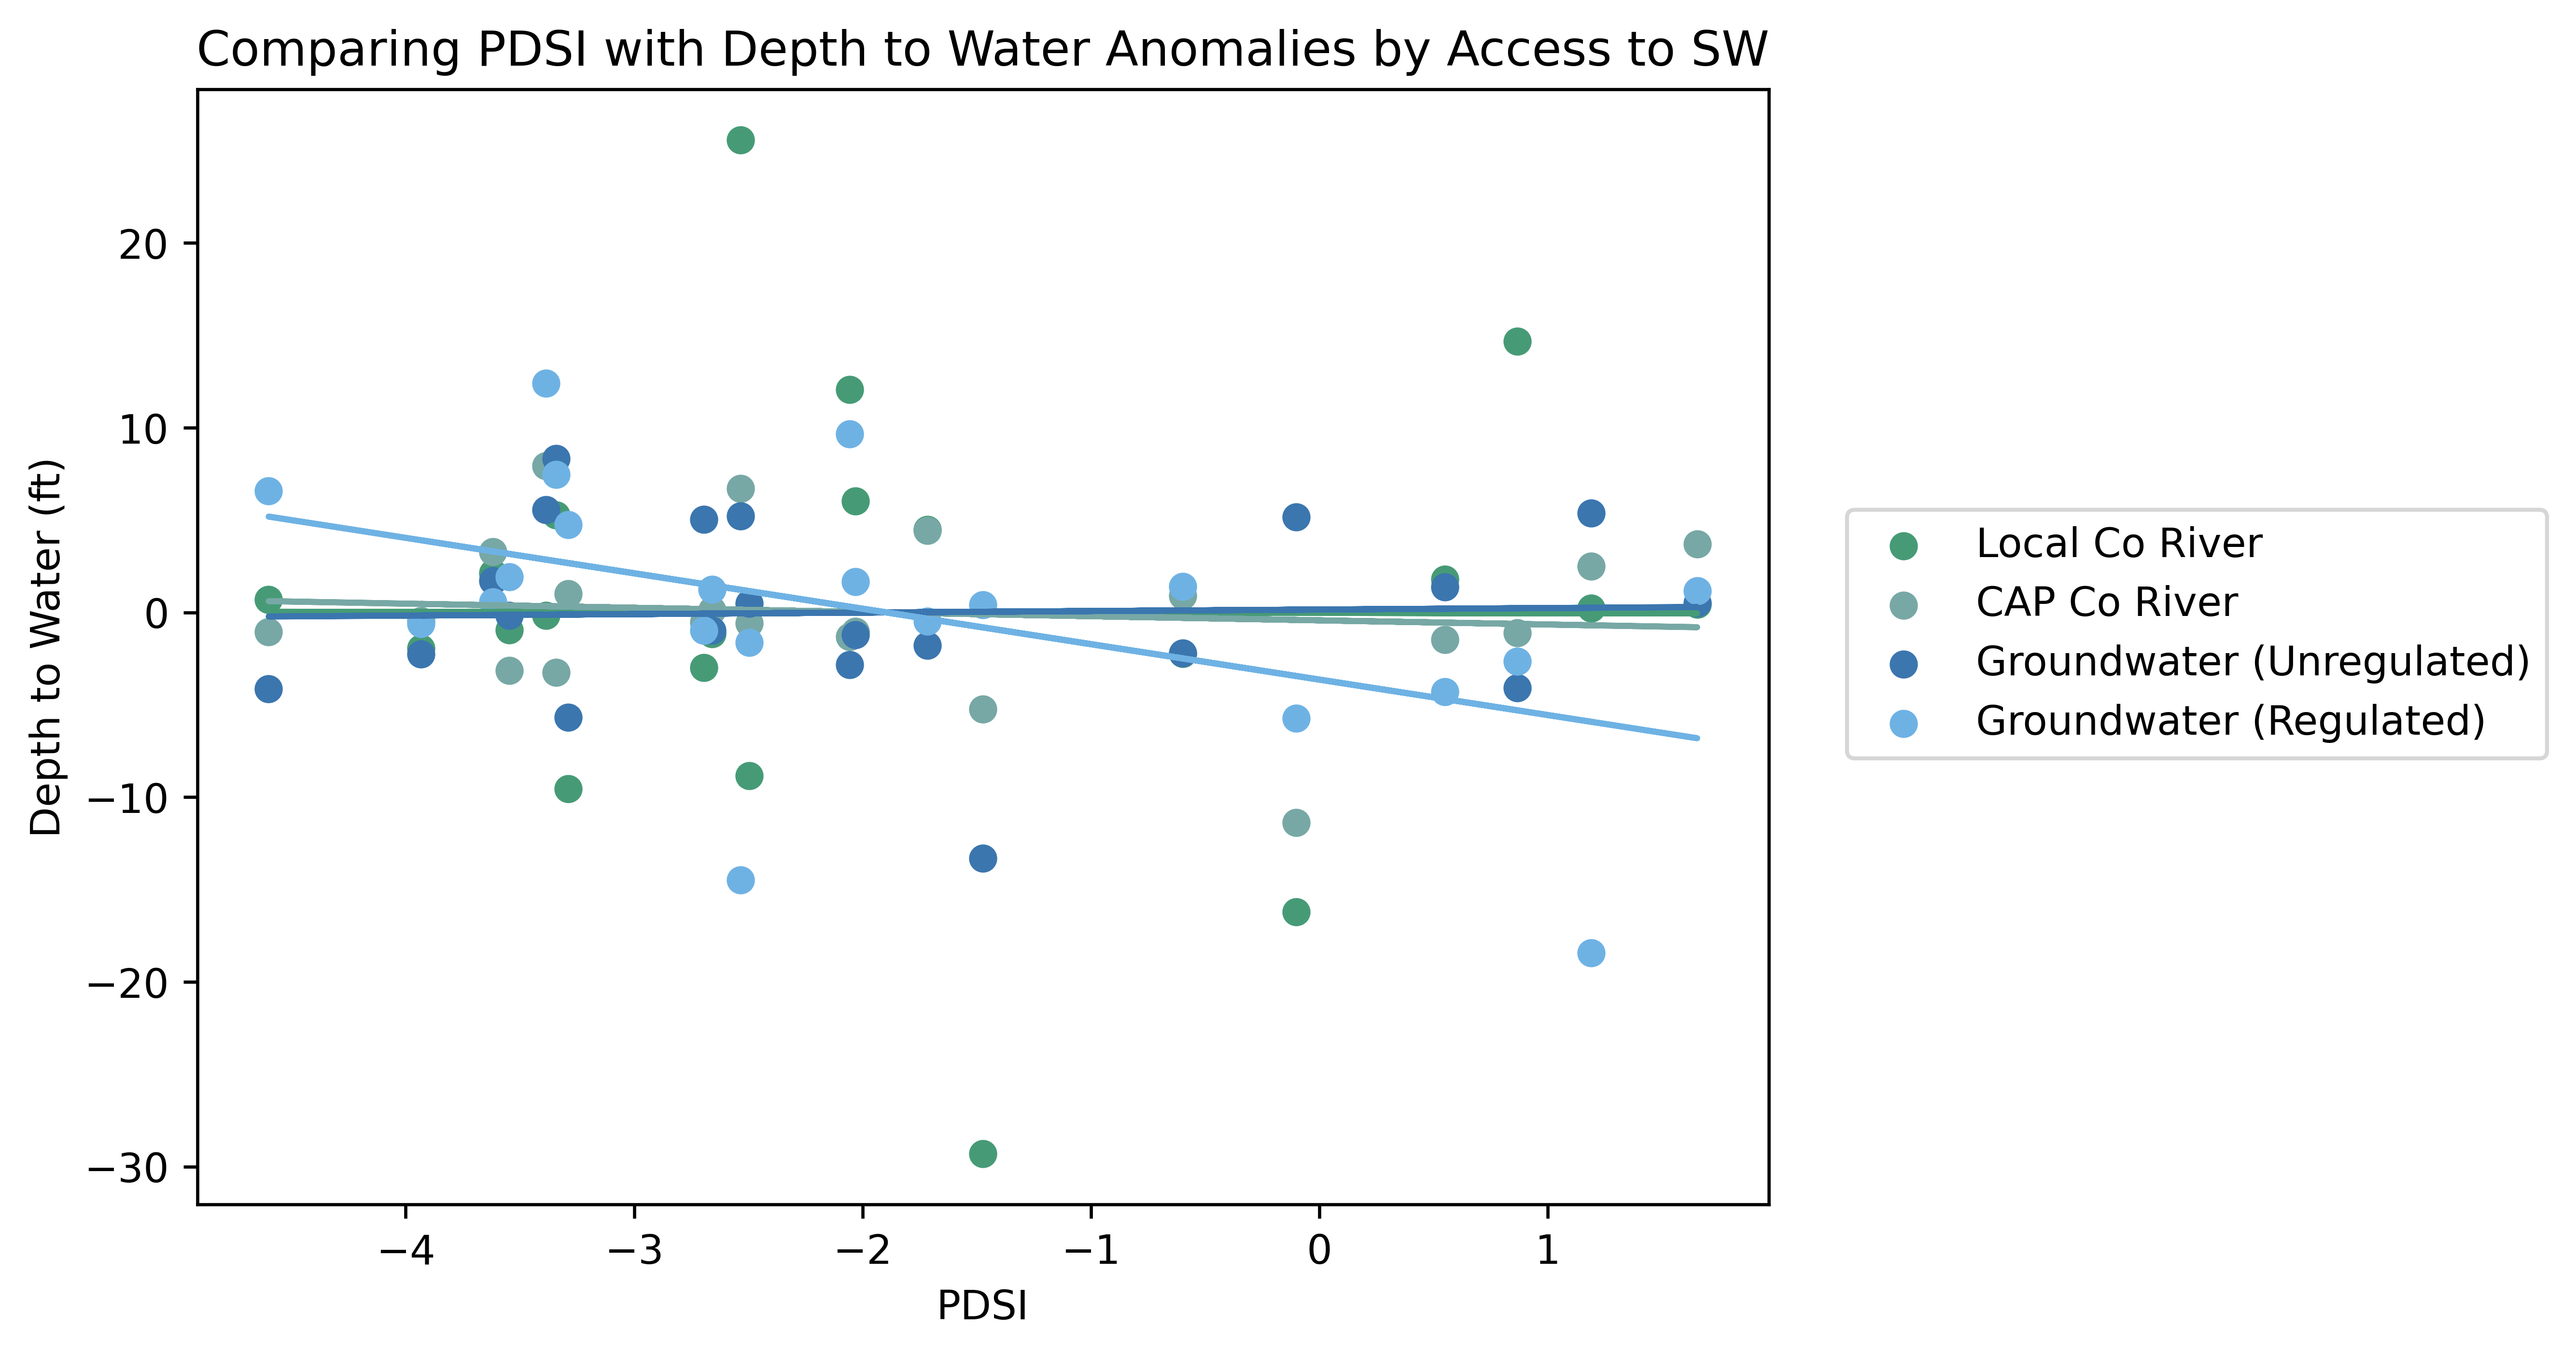

In [202]:
# %% Scatterplot of correlation values
ds = dtw_anomalys
name = 'Comparing PDSI with Depth to Water Anomalies by Access to SW'
# name = 'Comparing PDSI with Depth to Water by Regulation'
# del ds['Res']
columns = ds.columns
column_list = ds.columns.tolist()
# betterlabels = ['Receives CAP (Regulated)','GW Dominated (Regulated)','Surface Water Dominated','GW Dominated','Mixed Source'] 

fig, ax = plt.subplots(figsize = (7,5))
x = drought_indices['PDSI']
for i,j,k in zip(column_list
                # ,reg_colors
                # , SW_colors
                , colors
                , betterlabels
                ):
        y = ds[i]
        ax.scatter(x,y
                , label=k
                , color=j
                )
        # Trendline: 1=Linear, 2=polynomial
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        plt.plot(x, p(x),'-'
                , color=j
                # ,label=(k+' Trendline')
                )


ax.set_xlabel('PDSI')
ax.set_ylabel('Depth to Water (ft)')
ax.set_title(name,loc='center')
# ax.set_ylim(0,400)
fig.set_dpi(600)
plt.legend(loc = [1.05, 0.40])

plt.savefig(outputpath+name, bbox_inches='tight') 

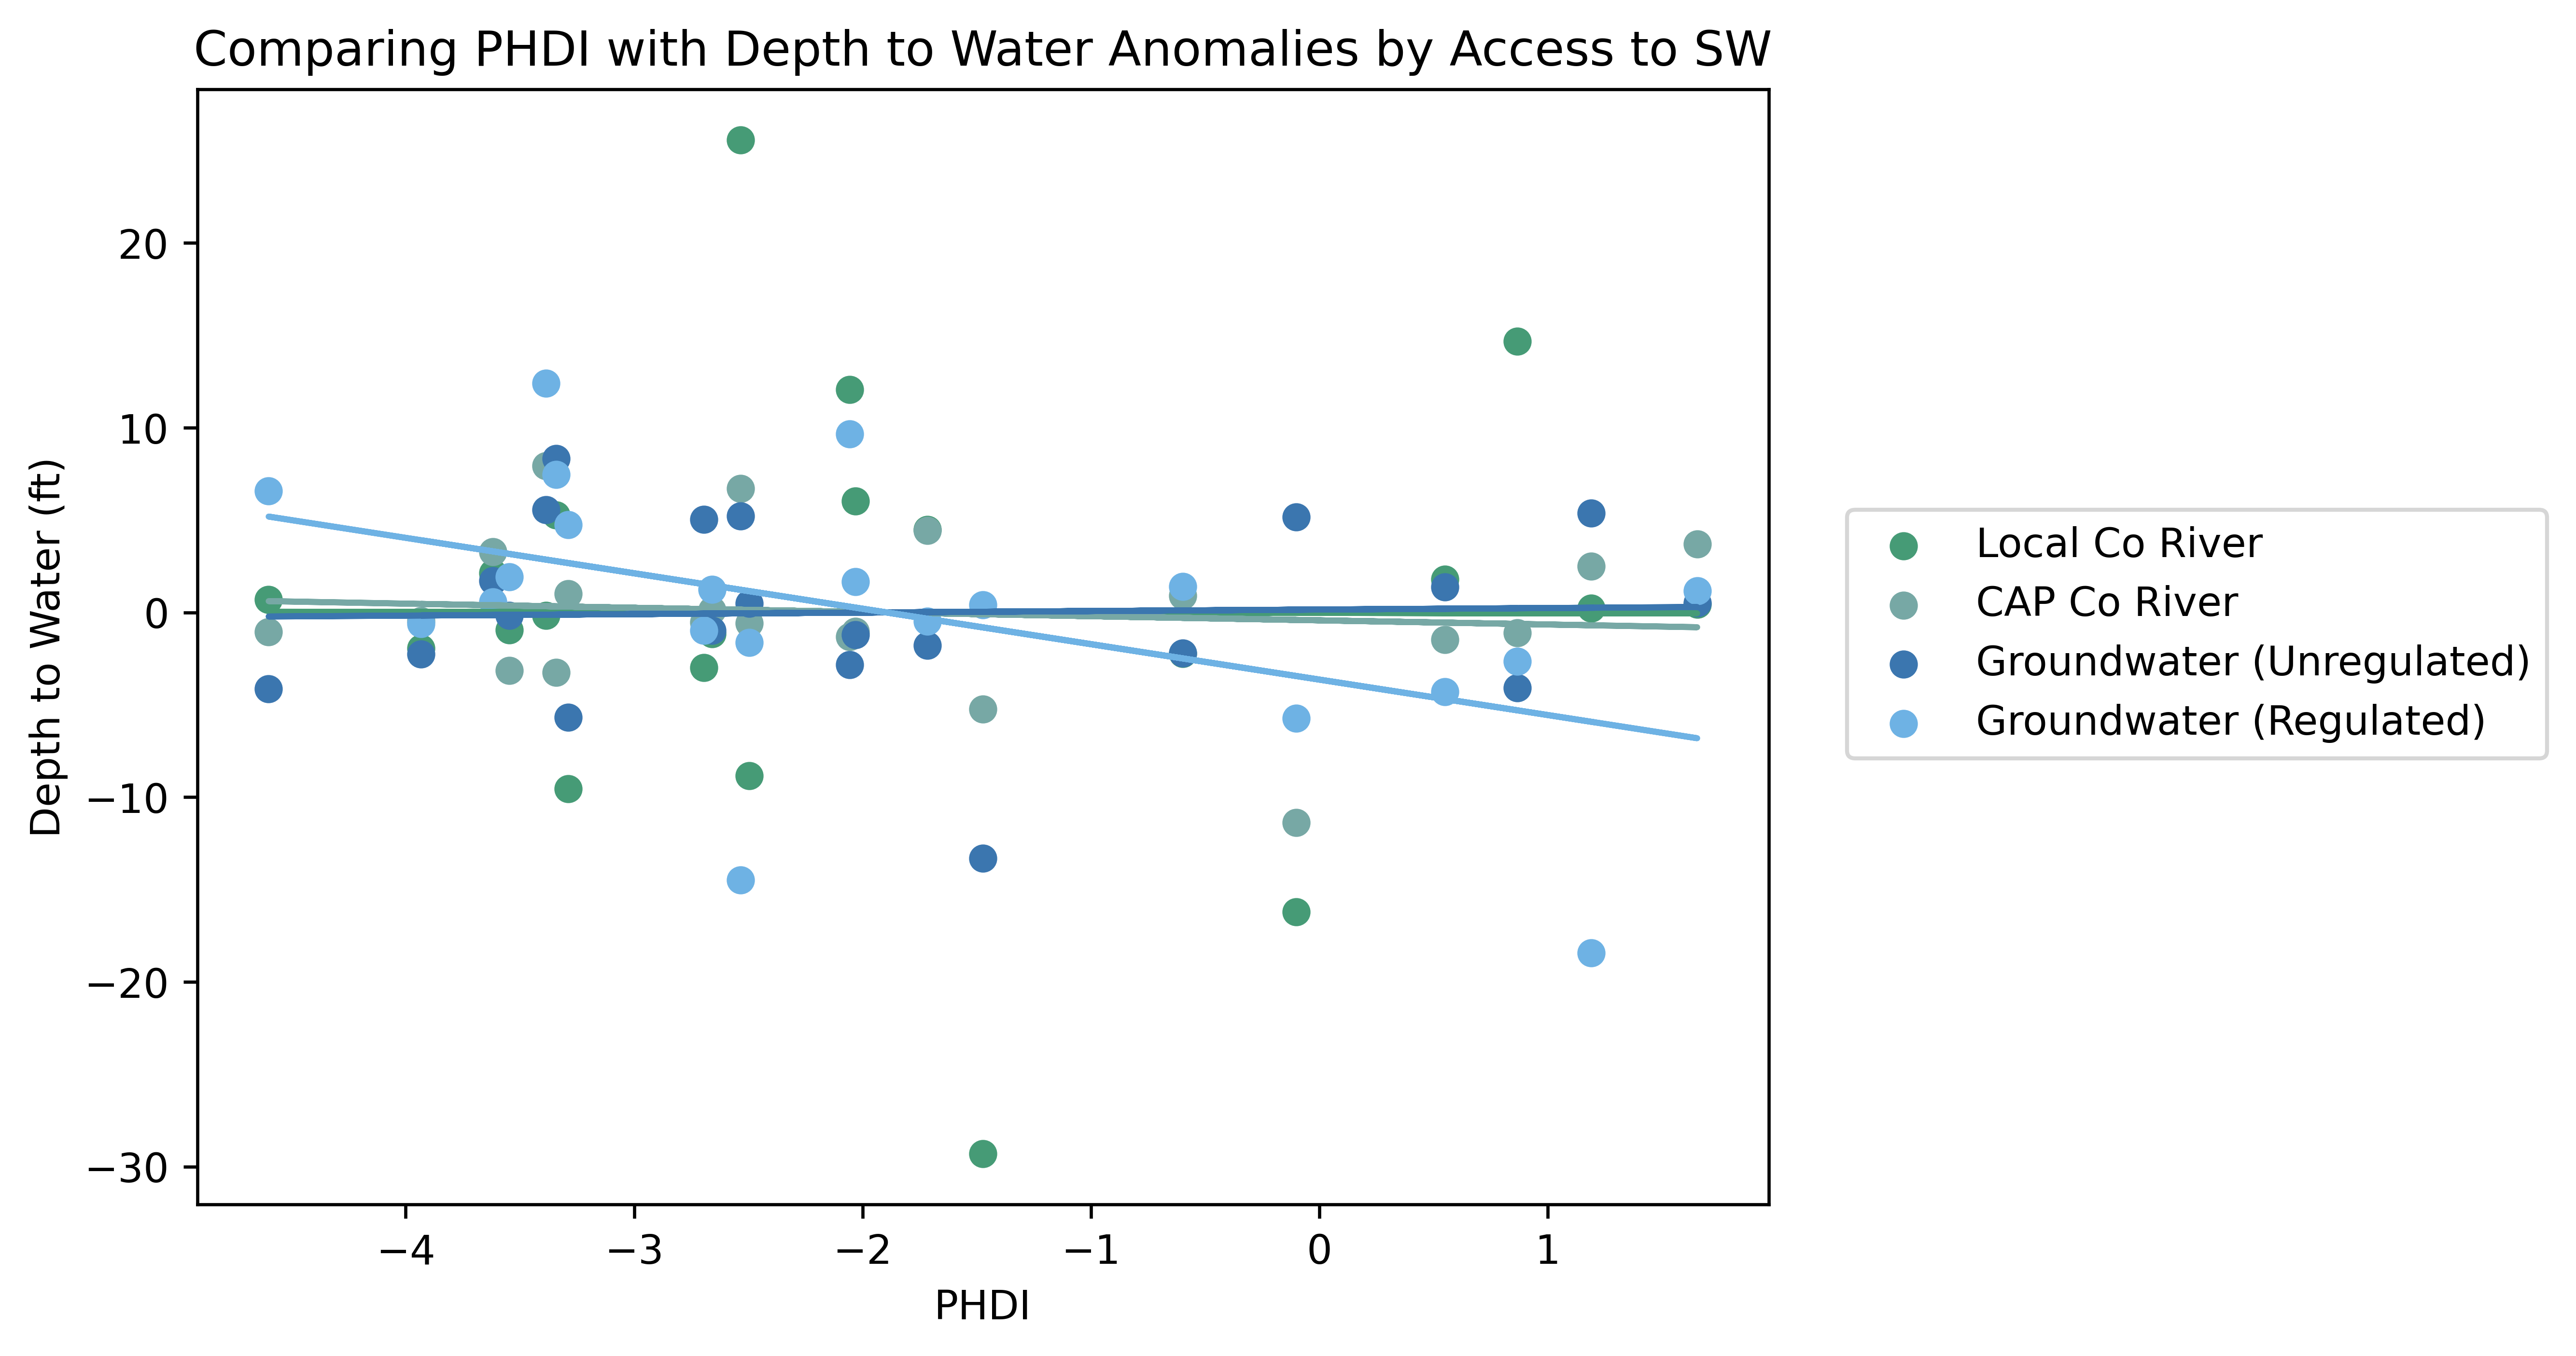

In [205]:
# %% Scatterplot of correlation values
ds = dtw_anomalys
name = 'Comparing PHDI with Depth to Water Anomalies by Access to SW'
# name = 'Comparing PDSI with Depth to Water by Regulation'
# del ds['Res']
columns = ds.columns
column_list = ds.columns.tolist()

fig, ax = plt.subplots(figsize = (7,5))
x = drought_indices['PDSI']
for i,j,k in zip(column_list
                # ,reg_colors
                # , SW_colors
                , colors
                , betterlabels
                ):
        y = ds[i]
        ax.scatter(x,y
                , label=k
                , color=j
                )
        # Trendline: 1=Linear, 2=polynomial
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        plt.plot(x, p(x),'-'
                , color=j
                # ,label=(k+' Trendline')
                )


ax.set_xlabel('PHDI')
ax.set_ylabel('Depth to Water (ft)')
ax.set_title(name,loc='center')
# ax.set_ylim(0,400)
fig.set_dpi(600)
plt.legend(loc = [1.05, 0.40])

plt.savefig(outputpath+name, bbox_inches='tight') 

Timeseries of DTW and DTW Anomalies

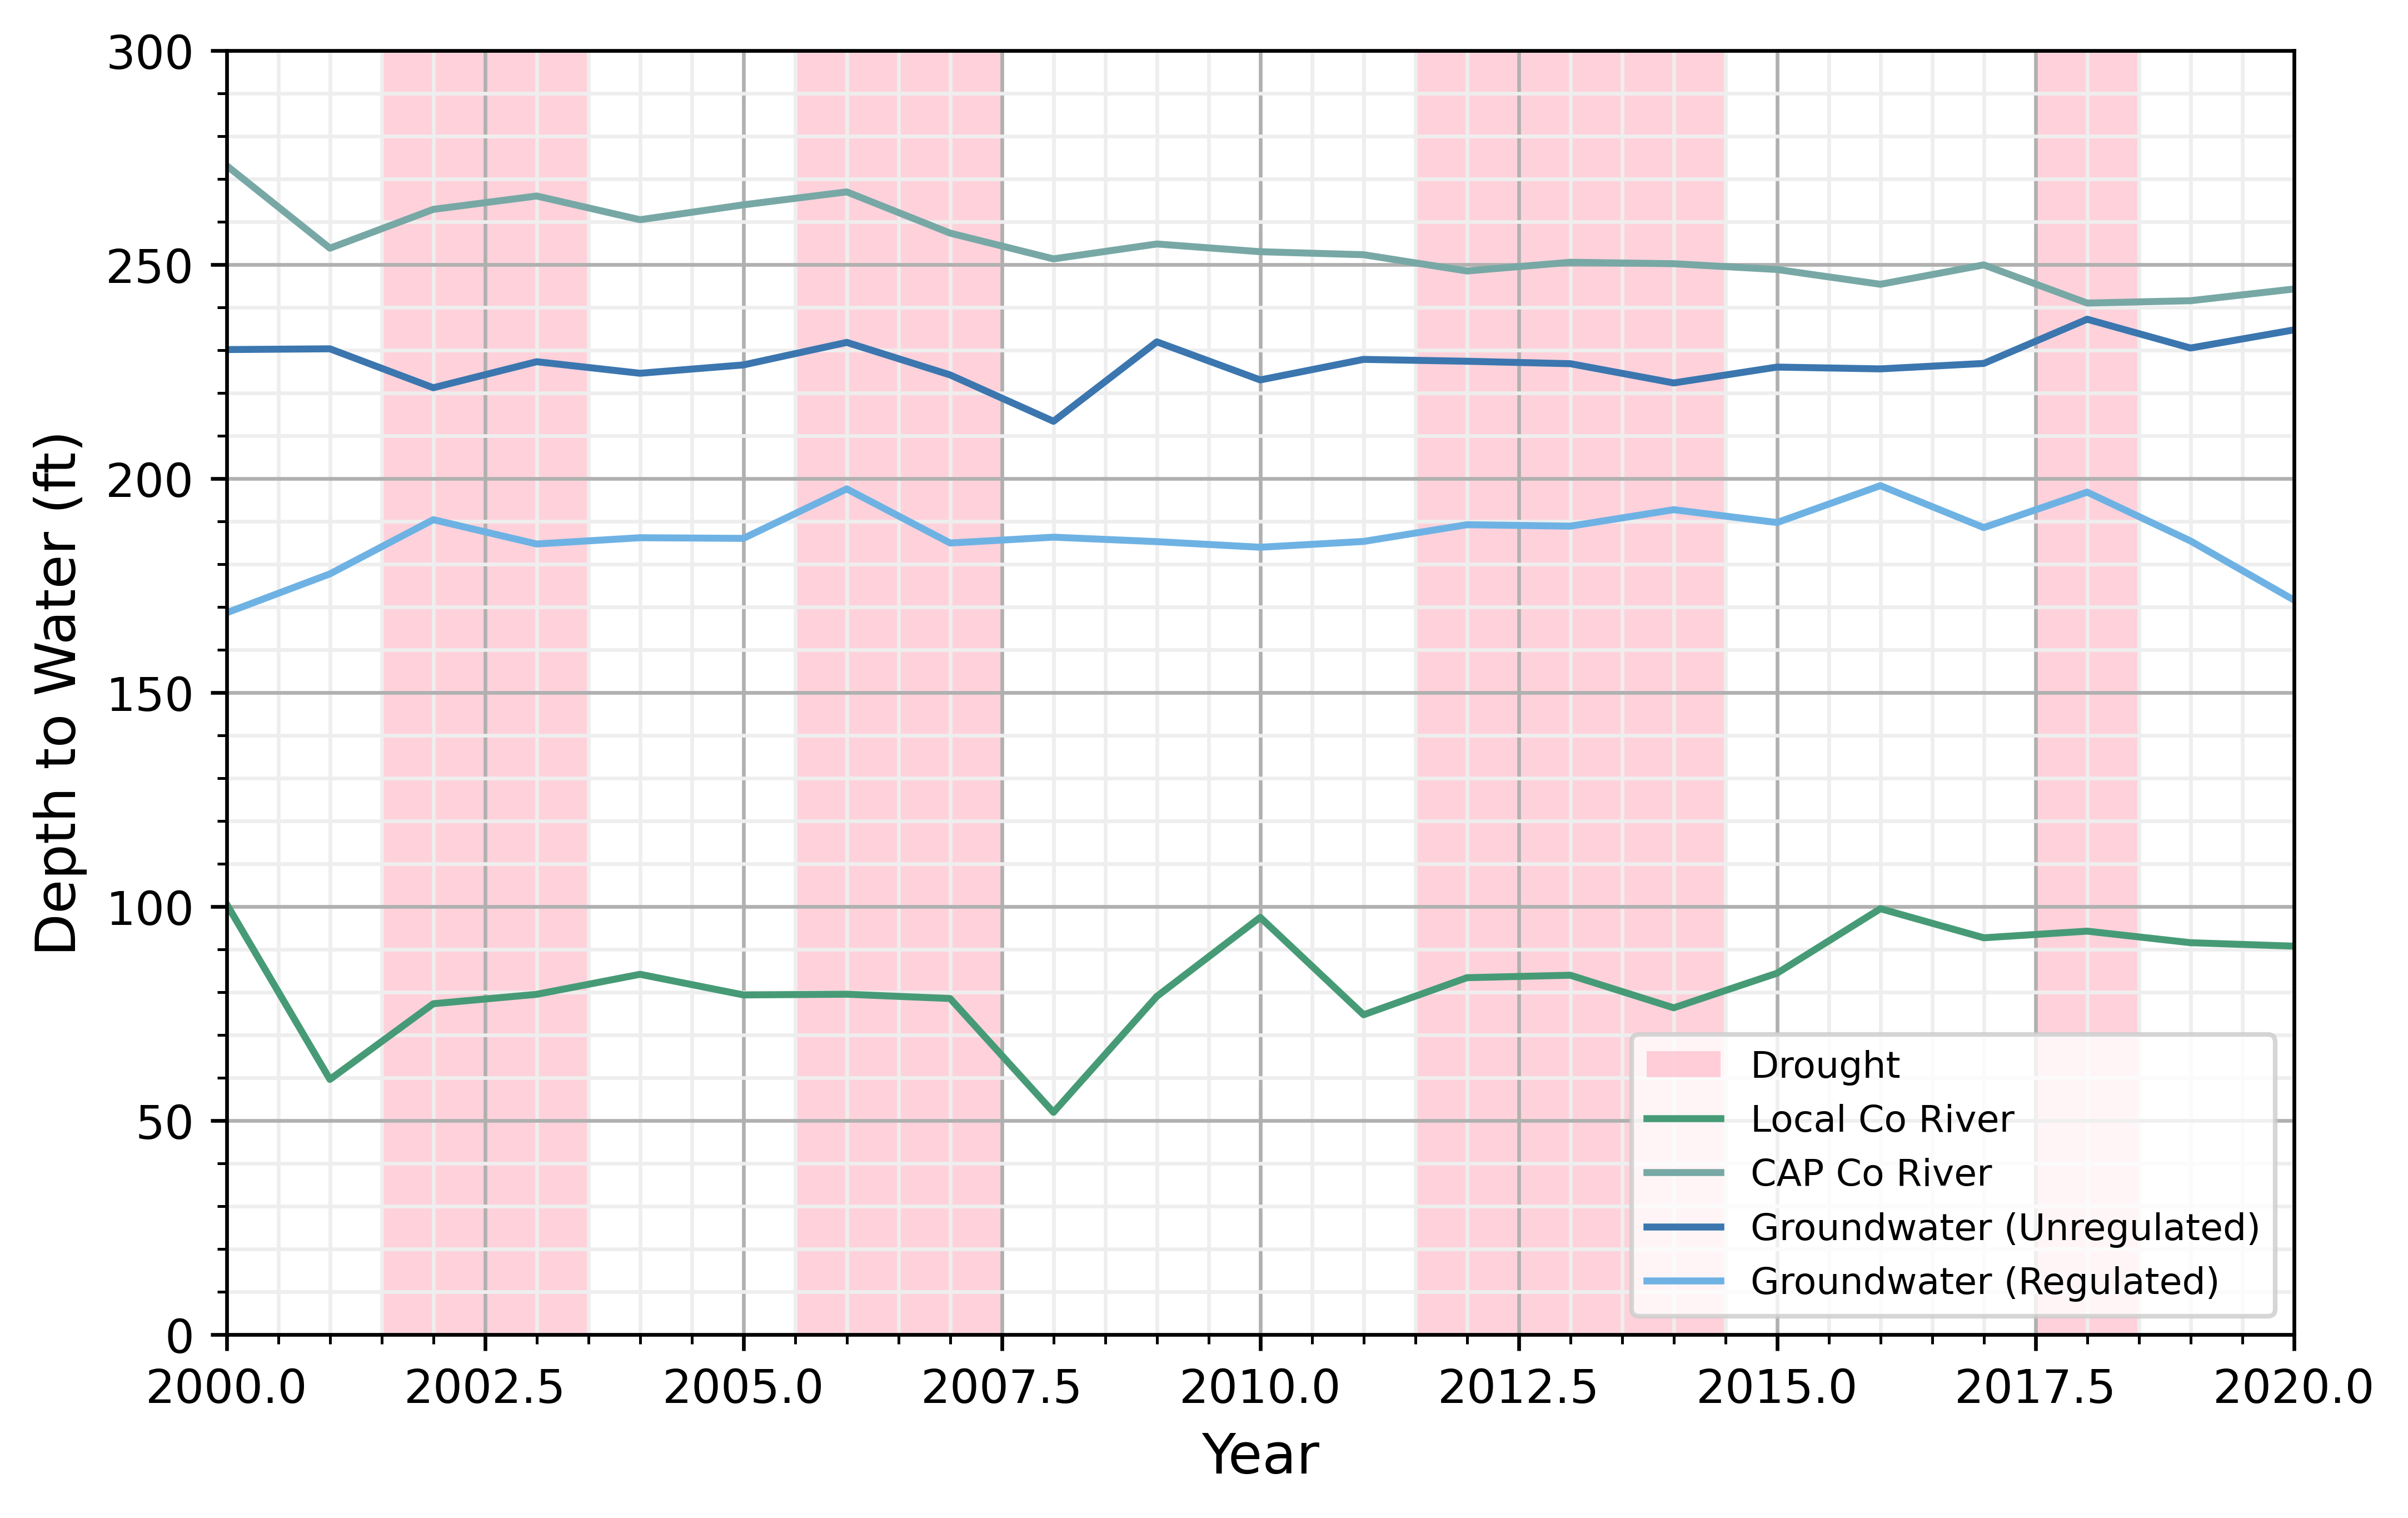

In [212]:
# For Depth to Water by SW Access
ds = wlanalysis_period
min_yr = 2000
mx_yr = 2020

fig, ax = plt.subplots(1, 1, figsize = (8,5))

# Drought Year Shading
a = 1988.5
b = 1990.5
c = 1995.5
d = 1996.5
# e = 1999.5
# f = 2000.5
g = 2001.5
h = 2003.5
i = 2005.5
j = 2007.5
k = 2011.5
l = 2014.5
m = 2017.5
n = 2018.5
plt.axvspan(a, b, color=drought_color, alpha=0.5, lw=0, label="Drought")
plt.axvspan(c, d, color=drought_color, alpha=0.5, lw=0)
# plt.axvspan(e, f, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(g, h, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(i, j, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(k, l, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(m, n, color=drought_color, alpha=0.5, lw=0)

min_y = 0
max_y = 300
fsize = 12

ax.plot(ds['SW'], label=betterlabels[0], color=swdom,zorder=2) 
ax.plot(ds['CAP'], label=betterlabels[1], color=cap,zorder=2)
ax.plot(ds['GW'], label=betterlabels[2], color=GWdom,zorder=2)  
ax.plot(ds['No_CAP'], label=betterlabels[3], color=mixed,zorder=2) 

ax.set_xlim([min_yr,mx_yr])
ax.set_ylim(min_y,max_y)
# ax.grid(True)
ax.grid(visible=True,which='major')
ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('Depth to Water (ft)',fontsize=fsize)
ax.minorticks_on()
fig.set_dpi(600.0)
# ax.set_title('c)',fontsize = fsize,loc='left',pad=15)
ax.legend(loc='lower right',fontsize = 8)

#Putting Grace on a secondary axis
# ax2 = ax.twinx()
# ax2.plot(grace_yearly['0'], label='State Average LWE', color='k',zorder=1)
# ax2.set_ylim([15, -15])
# ax2.set_ylabel(u'Δ LWE (cm)',fontsize=fsize)
# ax2.legend(loc='lower right')

# plt.savefig(figurepath+'Figure7c', bbox_inches = 'tight')

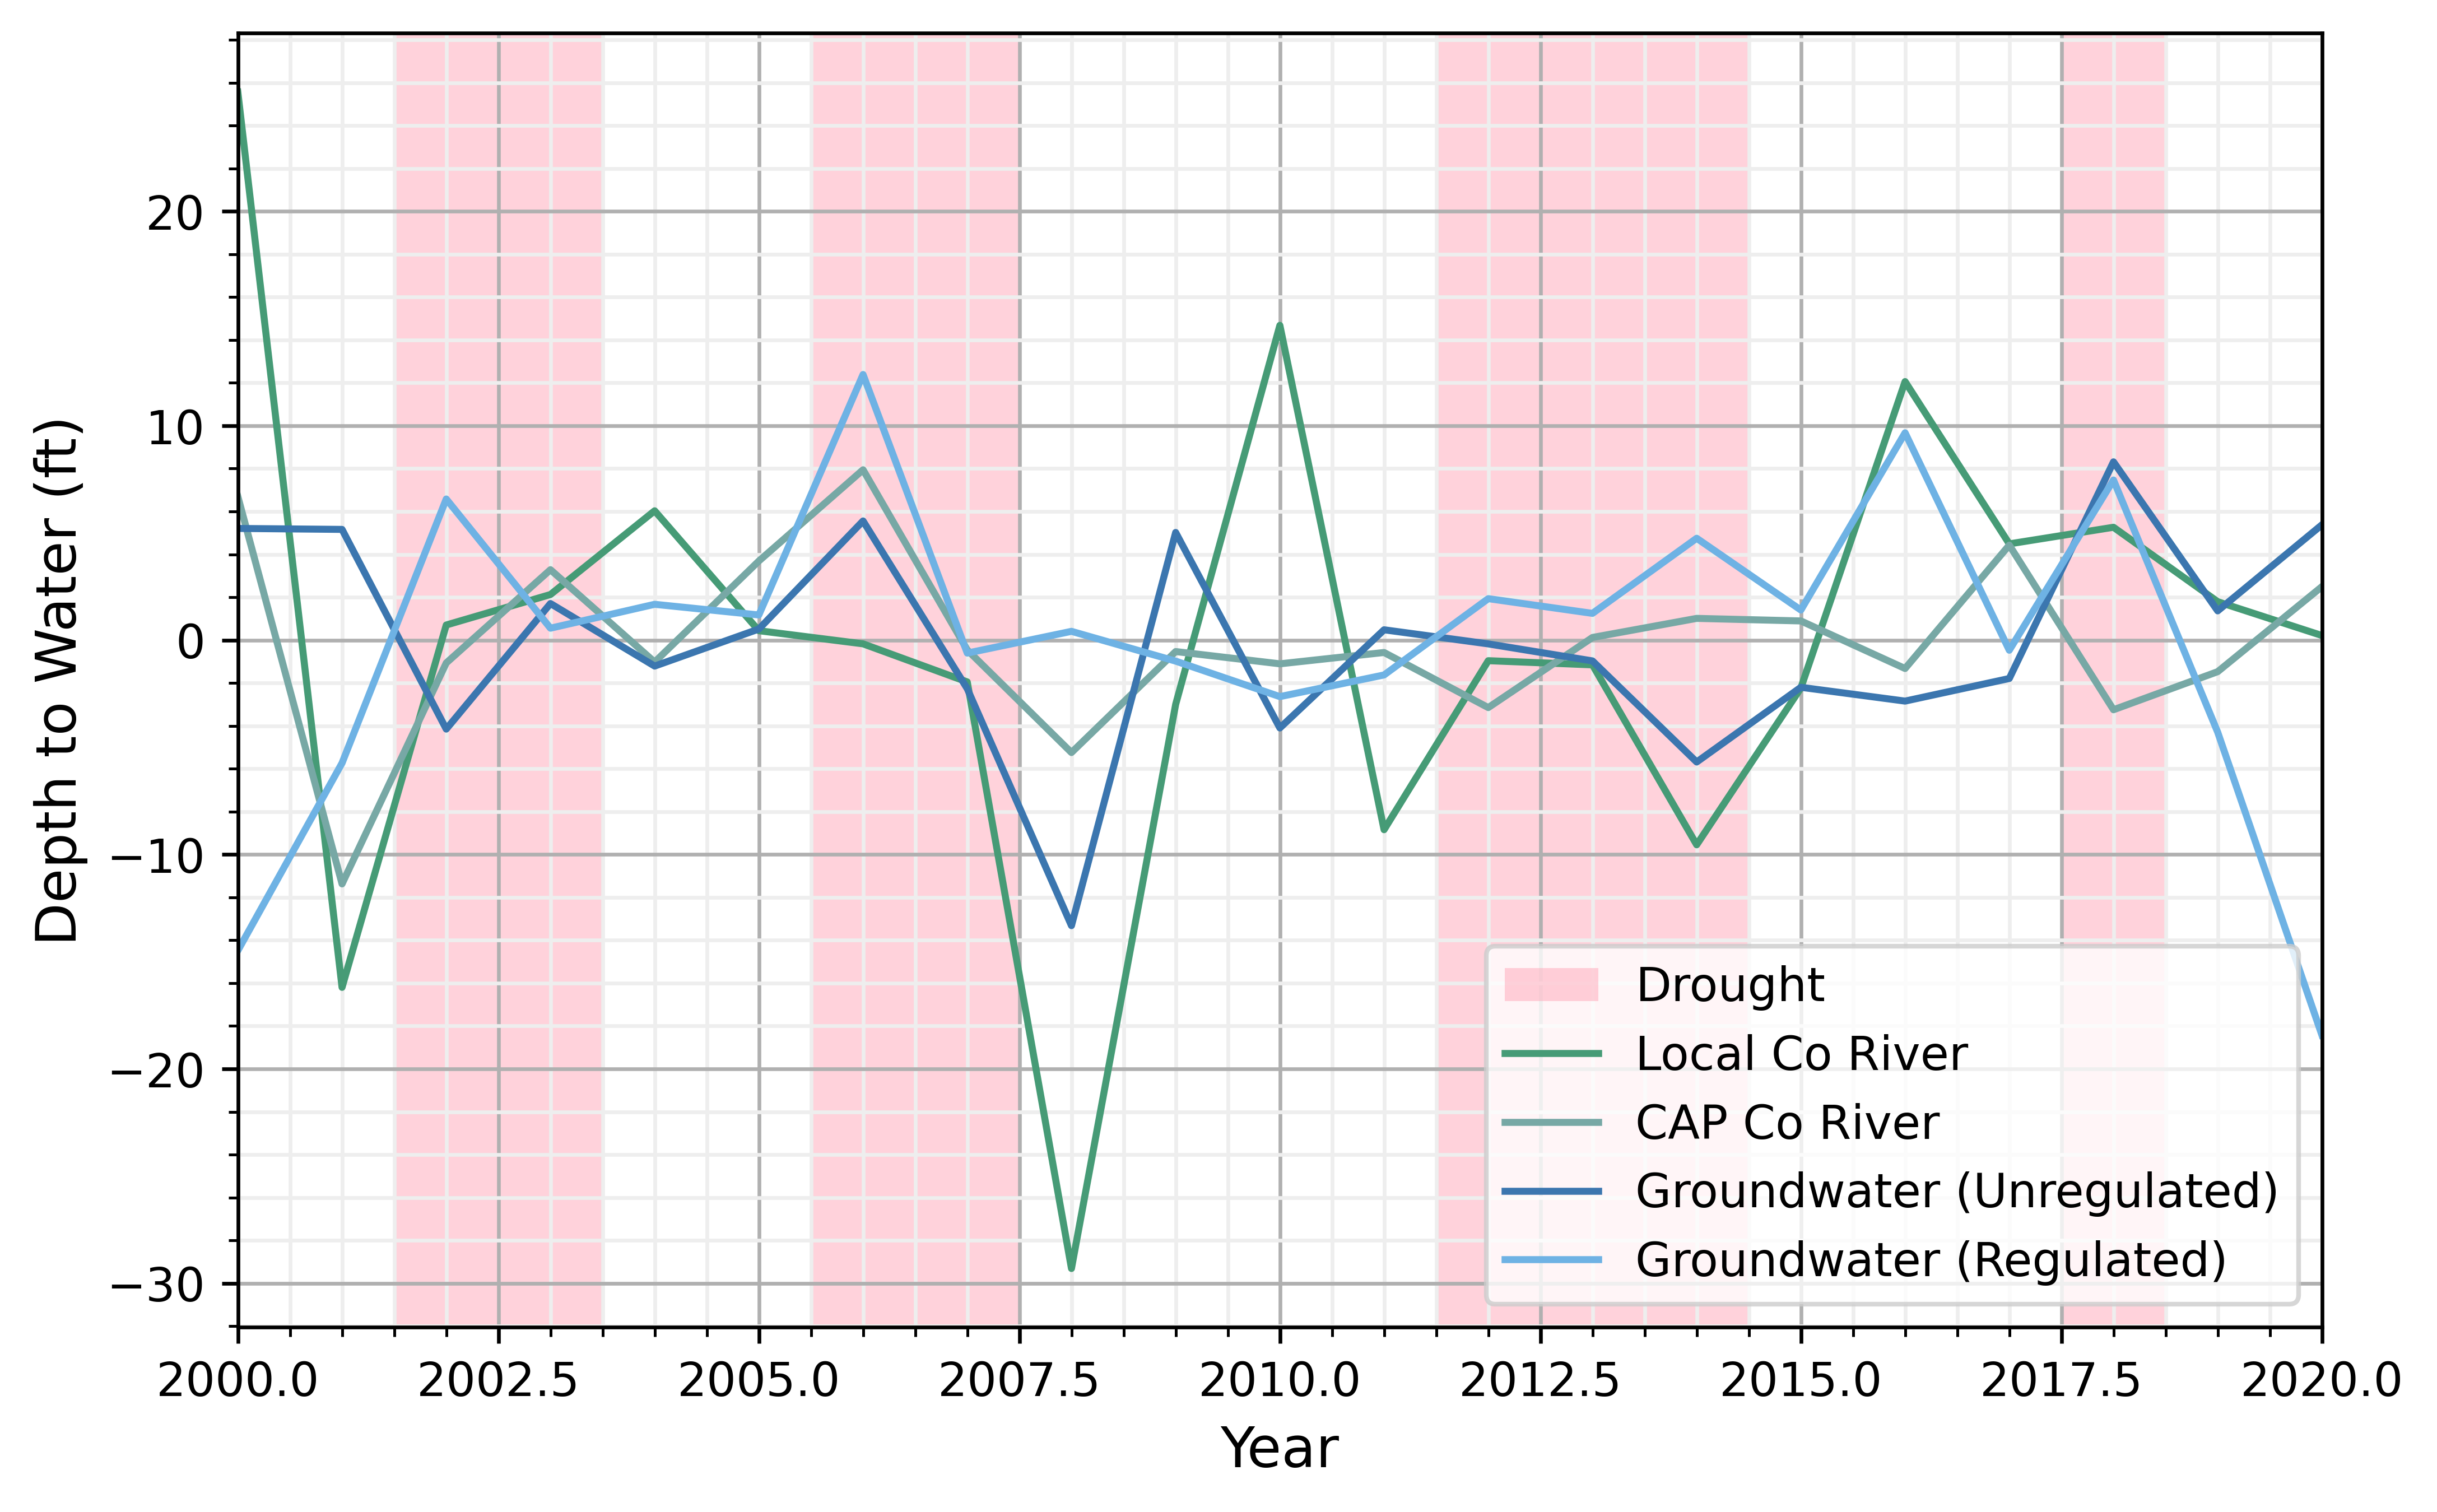

In [209]:
# For Depth to Water by SW Access
ds = dtw_anomalys
min_yr = 2000
mx_yr = 2020

fig, ax = plt.subplots(1, 1, figsize = (8,5))

# Drought Year Shading
a = 1988.5
b = 1990.5
c = 1995.5
d = 1996.5
# e = 1999.5
# f = 2000.5
g = 2001.5
h = 2003.5
i = 2005.5
j = 2007.5
k = 2011.5
l = 2014.5
m = 2017.5
n = 2018.5
plt.axvspan(a, b, color=drought_color, alpha=0.5, lw=0, label="Drought")
plt.axvspan(c, d, color=drought_color, alpha=0.5, lw=0)
# plt.axvspan(e, f, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(g, h, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(i, j, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(k, l, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(m, n, color=drought_color, alpha=0.5, lw=0)

min_y = 75
max_y = 300
fsize = 12

ax.plot(ds['SW'], label=betterlabels[0], color=swdom,zorder=2) 
ax.plot(ds['CAP'], label=betterlabels[1], color=cap,zorder=2)
ax.plot(ds['GW'], label=betterlabels[2], color=GWdom,zorder=2)  
ax.plot(ds['No_CAP'], label=betterlabels[3], color=mixed,zorder=2) 


ax.set_xlim([min_yr,mx_yr])
# ax.set_ylim(min_y,max_y)
# ax.grid(True)
ax.grid(visible=True,which='major')
ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('Depth to Water (ft)',fontsize=fsize)
ax.minorticks_on()
fig.set_dpi(600.0)
# ax.set_title('c)',fontsize = fsize,loc='left',pad=15)
ax.legend()

#Putting Grace on a secondary axis
# ax2 = ax.twinx()
# ax2.plot(grace_yearly['0'], label='State Average LWE', color='k',zorder=1)
# ax2.set_ylim([15, -15])
# ax2.set_ylabel(u'Δ LWE (cm)',fontsize=fsize)
# ax2.legend(loc='lower right')

plt.savefig(figurepath+'Figure7c', bbox_inches = 'tight')

Calculating the drawdown (max anomaly)

In [214]:
# %% Average Anomalie for drought periods
ds = dtw_anomalys.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


dtw_max_anomalies = ds.groupby(['Status']).max()
dtw_max_anomalies
# ds

SW       CAP        GW     No_CAP
Status                                              
Drought 3    2.126550  3.285556  1.706694   6.582429
Drought 4   -0.173882  7.945816  5.558312  12.390334
Drought 5   -0.959773  1.013783 -0.176282   4.750863
Drought 6    5.264458 -3.248522  8.315579   7.468134
Normal-Wet  25.564871  6.699278  5.377583   9.670862

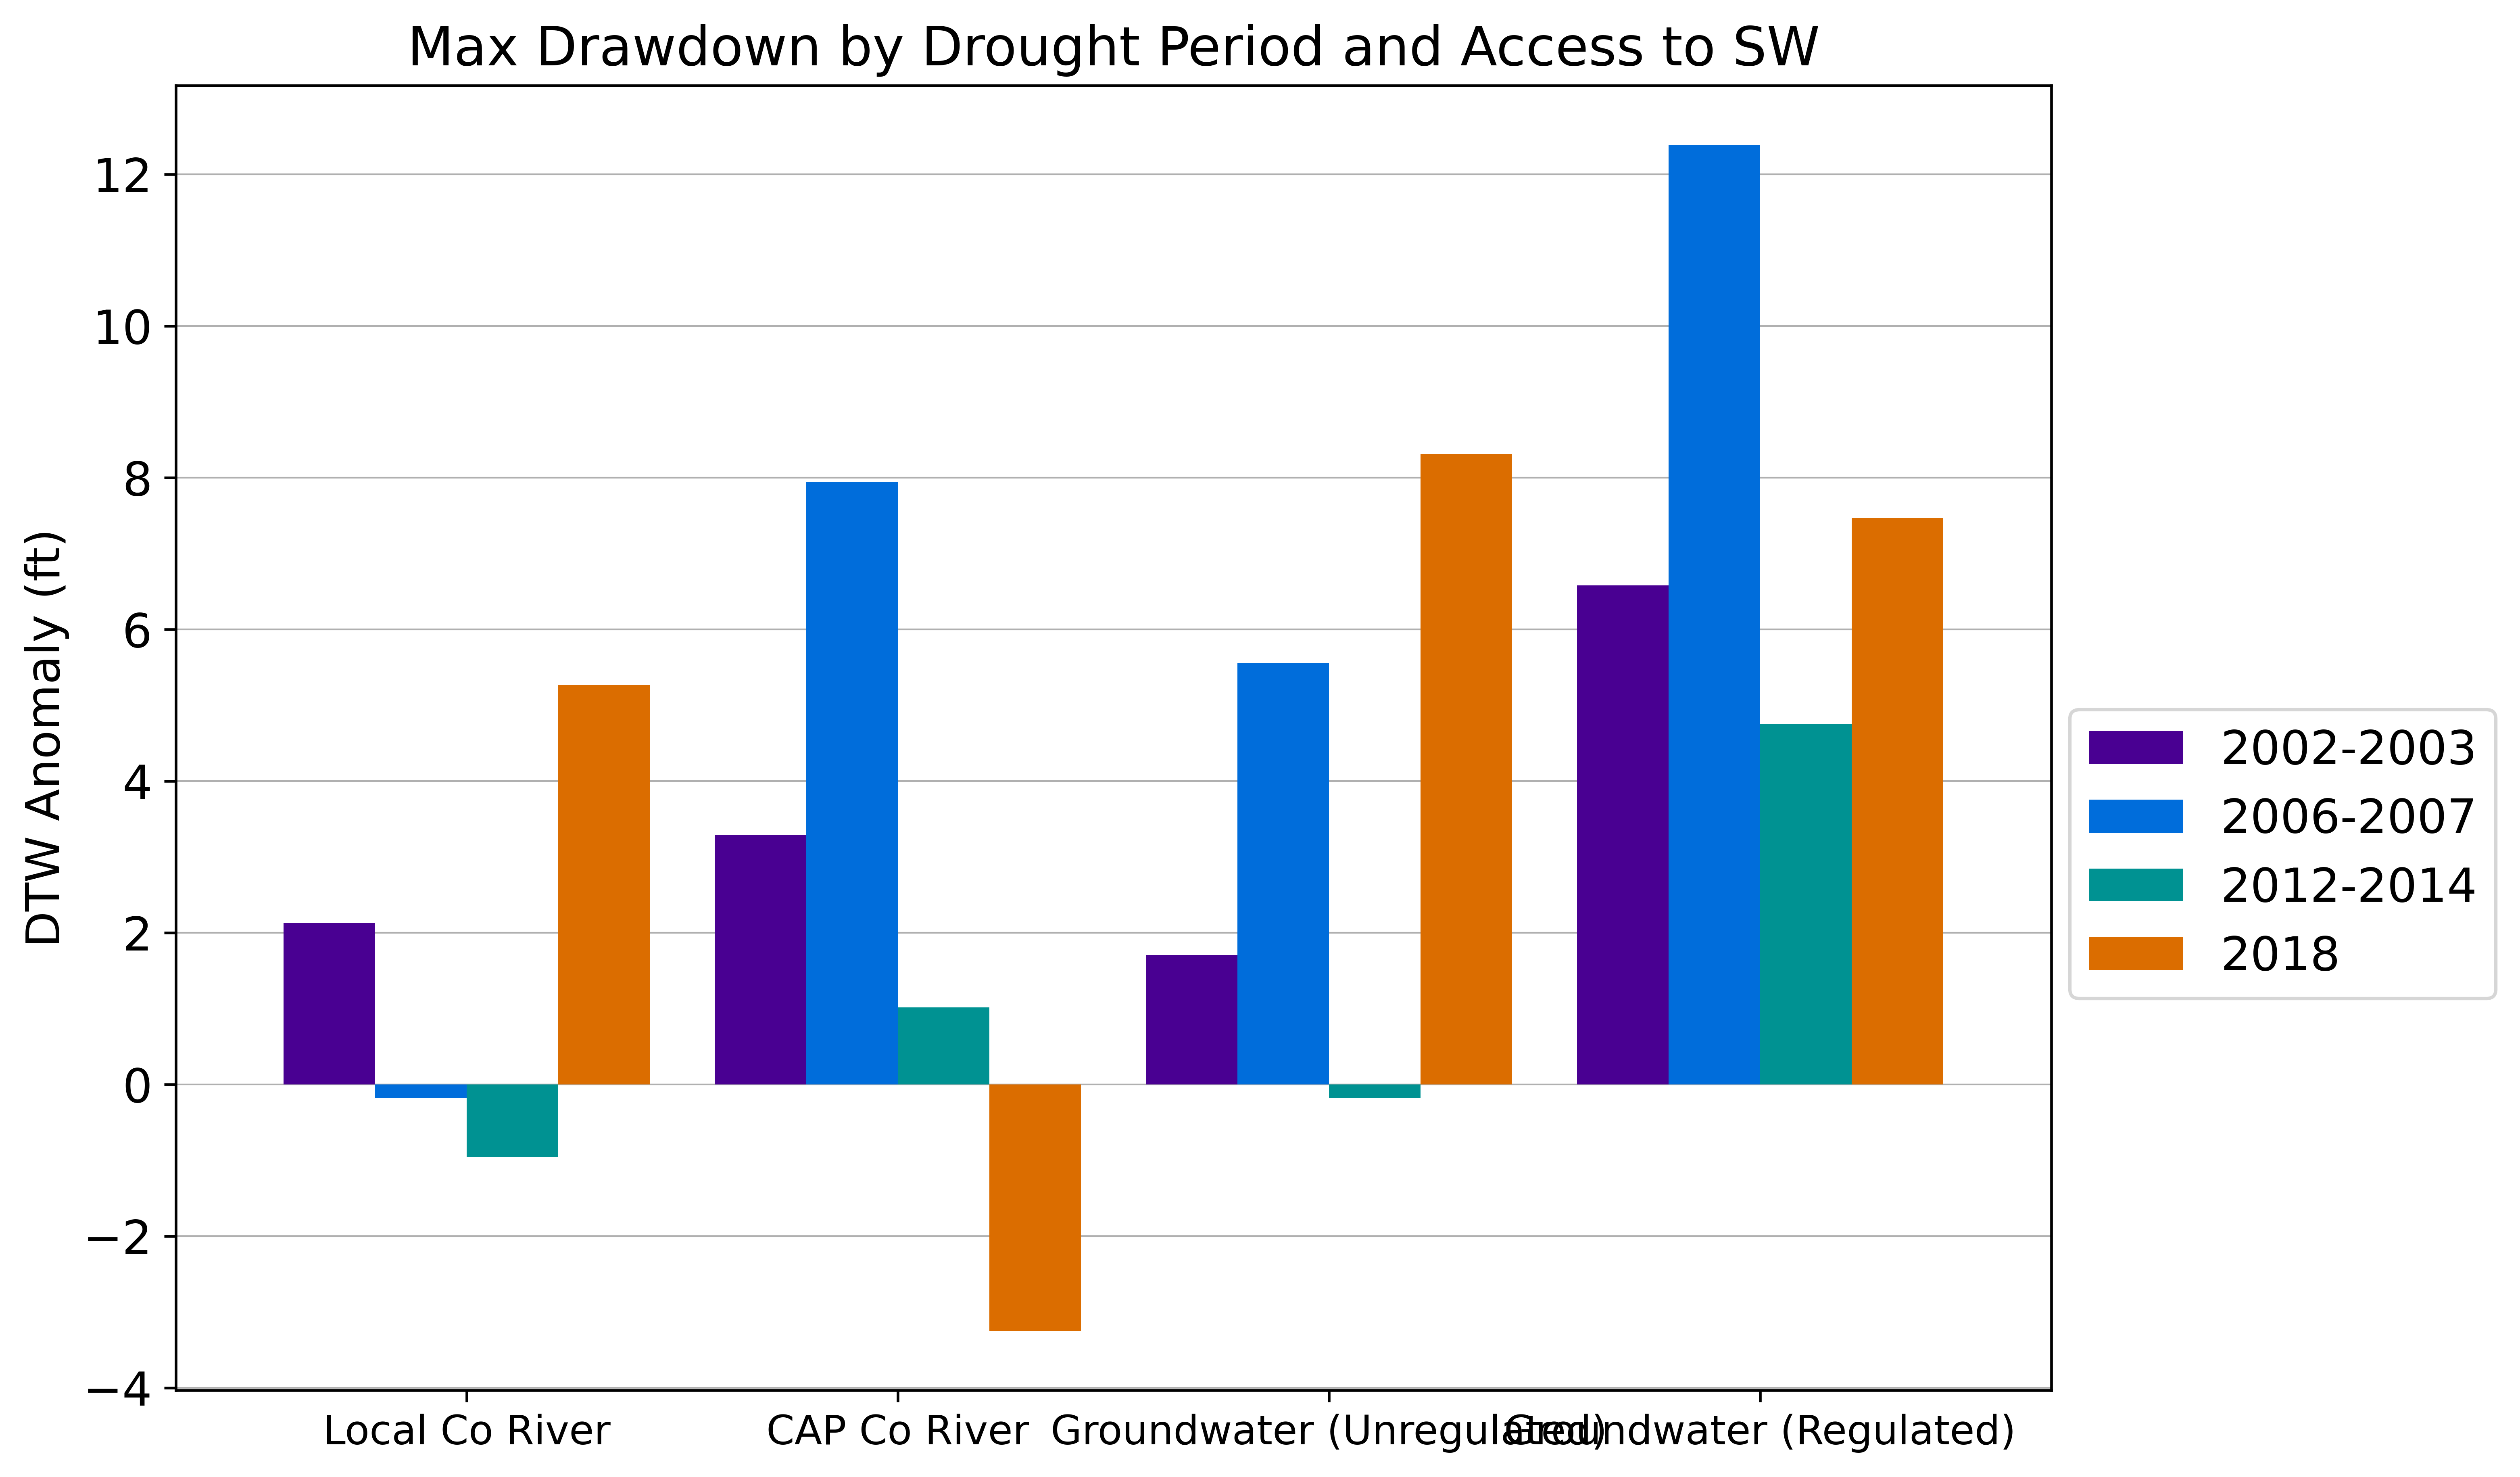

In [215]:
#%% Grouped Bar chart for drawdown (ft)
# name = 'Average DTW Anomalies by Drought Period and Groundwater Regulation'
name = 'Max Drawdown by Drought Period and Access to SW'

yearlabels = [
                # "1989-1990"
        #       ,'1996',
              '2002-2003','2006-2007','2012-2014','2018'
              ,'Normal/Wet Years'
        ]


dtw_max_anomalies.index = yearlabels
dtw_max_anomalies = dtw_max_anomalies.transpose()

dtw_max_anomalies.index = betterlabels
del dtw_max_anomalies['Normal/Wet Years']
dtw_max_anomalies


# group_colors = ['lightsalmon','tomato','orangered','r','brown','indianred','steelblue']

group_colors = [blind[5],blind[6],blind[2]
                ,blind[12],blind[11],blind[10]
                # ,blind[0] #black
                ]

horlabel = 'DTW Anomaly (ft)'
fsize = 14

plt.rcParams["figure.dpi"] = 600
dtw_max_anomalies.plot(figsize = (10,7),
        kind='bar',
        stacked=False,
        # title=name,
        color = group_colors,
        zorder = 2,
        width = 0.85,
        fontsize = fsize
        )
plt.title(name, fontsize = (fsize+2))
# plt.ylim([0,400])
plt.ylabel(horlabel, fontsize = fsize)
plt.xticks(rotation=0, fontsize = fsize-2)
plt.grid(axis='y', linewidth=0.5, zorder=0)
plt.legend(loc=[1.01,0.3],fontsize = fsize)
# plt.set_dpi(600)

plt.savefig(figurepath+name+'_groupedchart', bbox_inches = 'tight')
# plt.savefig(outputpath+name+'_anomalies_SWAccess_groupedchart', bbox_inches = 'tight')

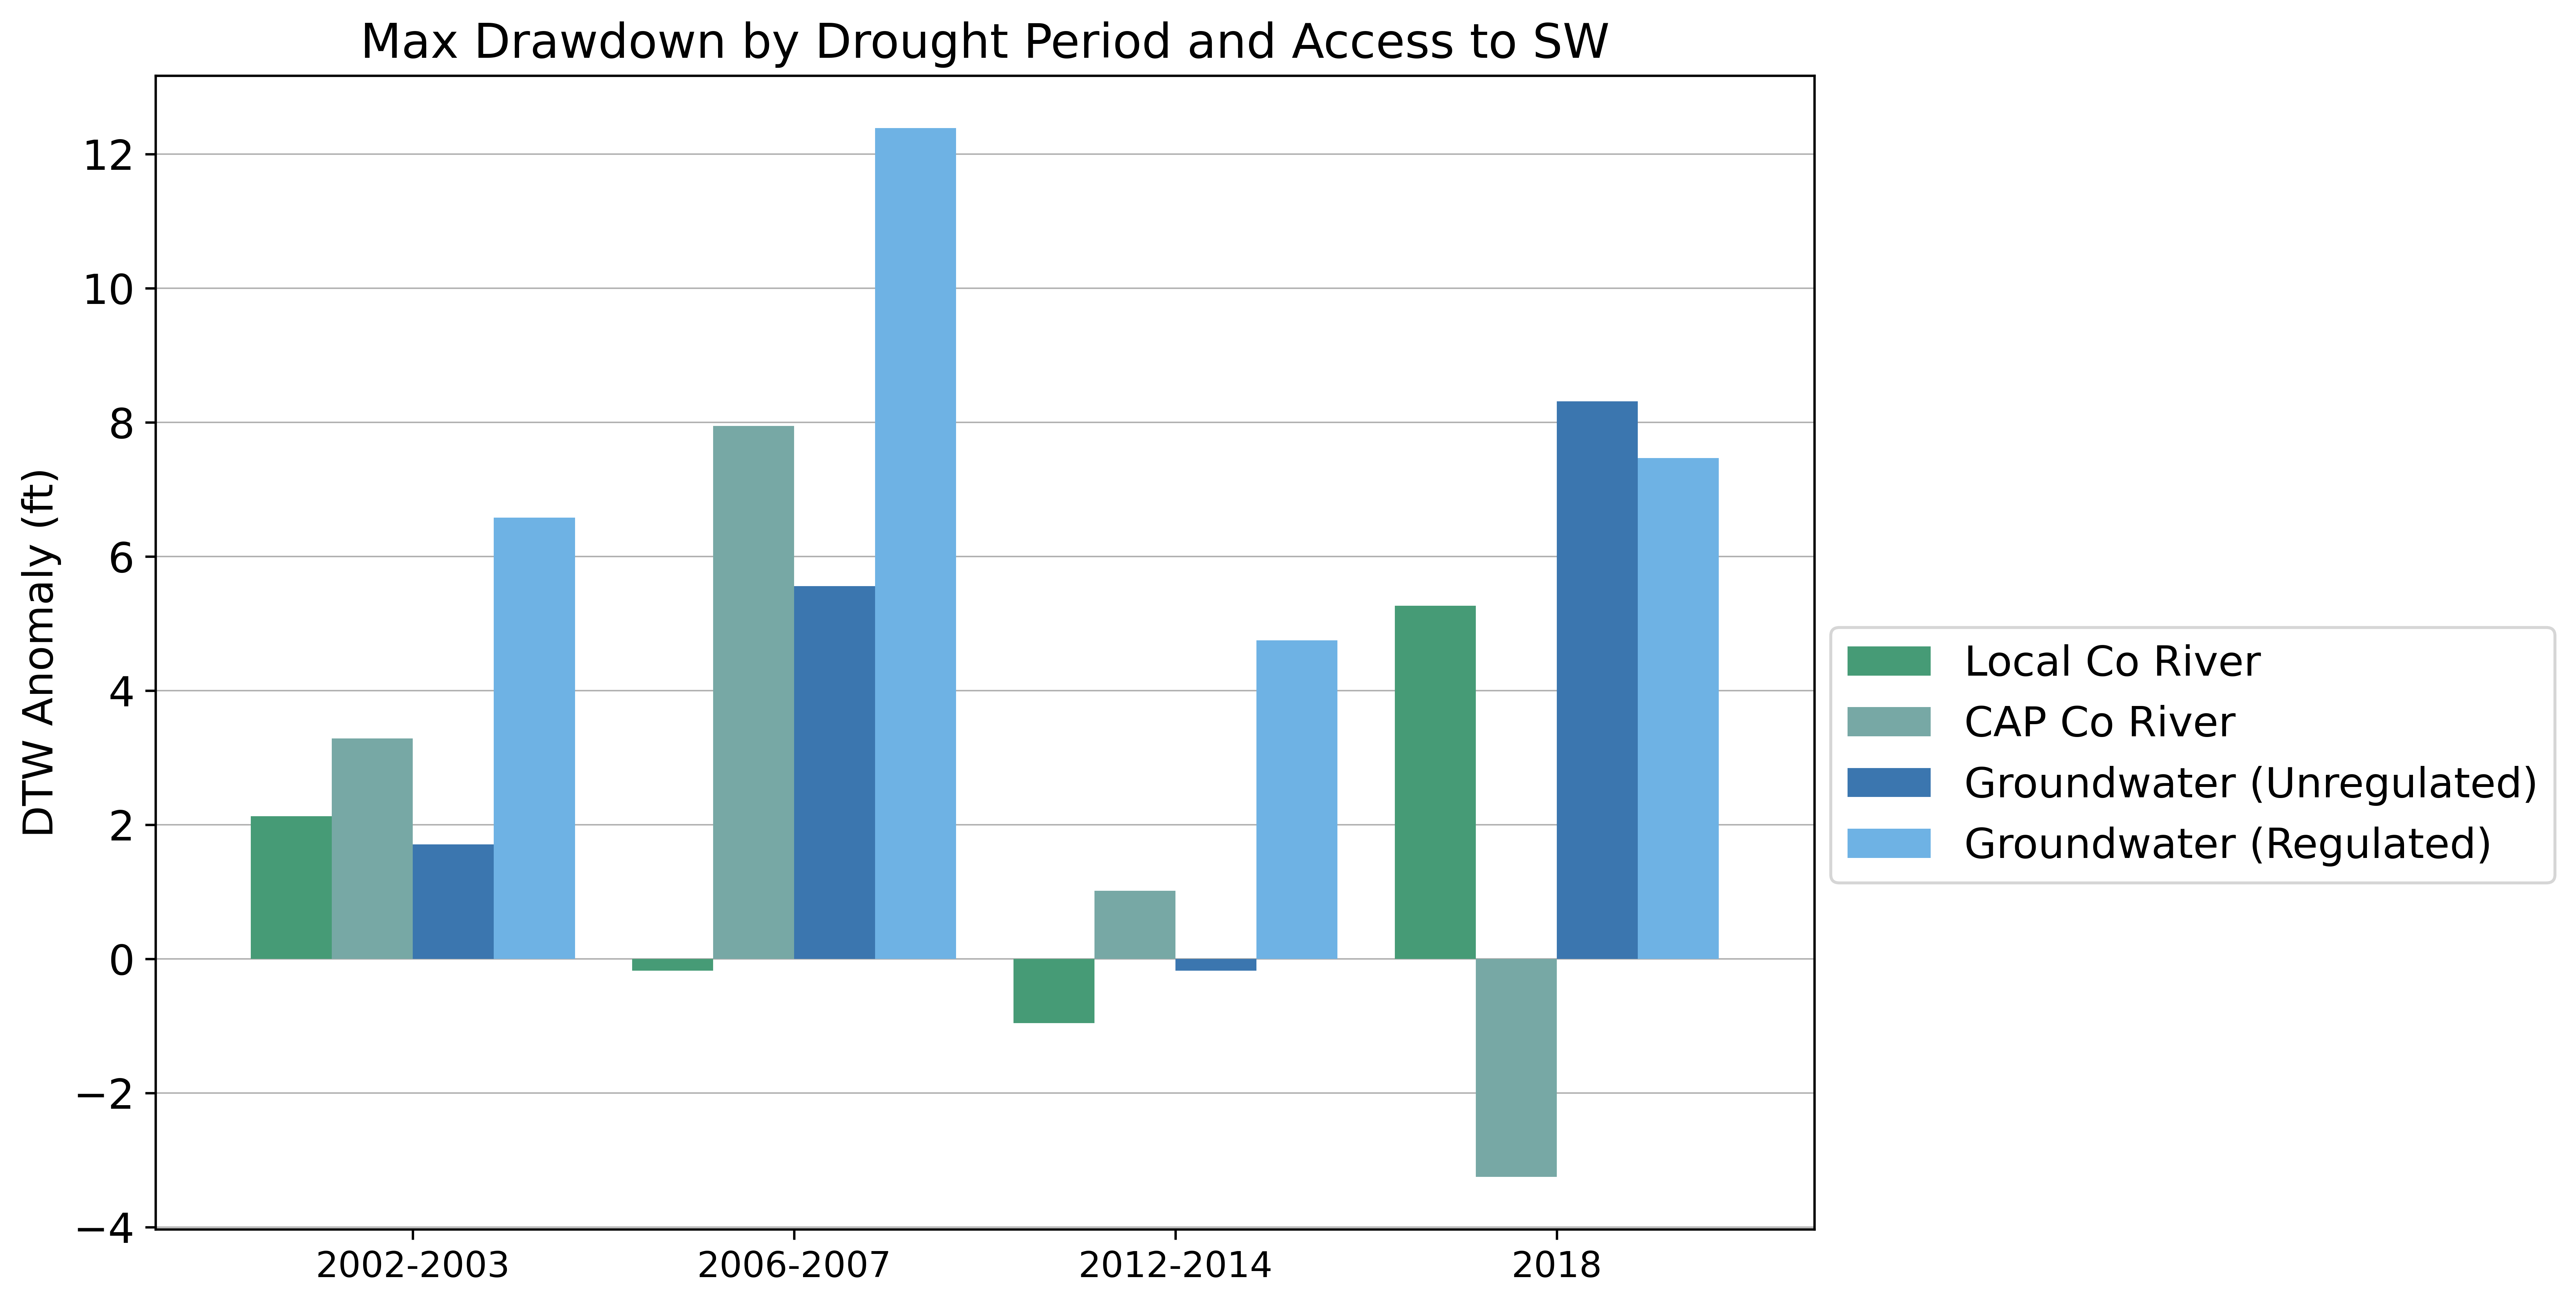

In [216]:
#%% Grouped Bar chart for drawdown (ft)
# name = 'Average DTW Anomalies by Drought Period and Groundwater Regulation'
name = 'Max Drawdown by Drought Period and Access to SW'

dtw_max_anomalies = dtw_max_anomalies.transpose()


# group_colors = ['lightsalmon','tomato','orangered','r','brown','indianred','steelblue']

# group_colors = [blind[5],blind[6],blind[2]
#                 ,blind[12],blind[11],blind[10]
#                 # ,blind[0] #black
#                 ]

group_colors = colors

horlabel = 'DTW Anomaly (ft)'
fsize = 14

plt.rcParams["figure.dpi"] = 600
dtw_max_anomalies.plot(figsize = (10,7),
        kind='bar',
        stacked=False,
        # title=name,
        color = group_colors,
        zorder = 2,
        width = 0.85,
        fontsize = fsize
        )
plt.title(name, fontsize = (fsize+2))
# plt.ylim([0,400])
plt.ylabel(horlabel, fontsize = fsize)
plt.xticks(rotation=0, fontsize = fsize-2)
plt.grid(axis='y', linewidth=0.5, zorder=0)
plt.legend(loc=[1.01,0.3],fontsize = fsize)
# plt.set_dpi(600)

plt.savefig(figurepath+name+'_groupedchart_transposed', bbox_inches = 'tight')
# plt.savefig(outputpath+name+'_anomalies_SWAccess_groupedchart', bbox_inches = 'tight')